In [1]:
# filter all the warnings
import warnings
warnings.filterwarnings("ignore")

# data manipulation tools
import pandas as pd
import pandas
import numpy as np

# modeling tools
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from optuna import Trial
from sklearn.metrics import f1_score
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
# from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from autogluon.tabular import TabularDataset, TabularPredictor


# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.express as px
pyo.init_notebook_mode()

# model metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

# hyperparameter tuning
import optuna

# model interpretation
import shap
shap.initjs()

# miscellaneous
from pprint import pprint
from joblib import dump
from tqdm import tqdm
from typing import Union, Callable, Tuple, List
import os


In [2]:
data = pd.read_csv('encoded_dataset.csv')
data

Unnamed: 0   Age  Clarity  Color  Transparency  Spec Gravity  pH Level  \
0             0  23.0        1      4             0         1.005       5.0   
1             1  44.0        0      4             2         1.020       6.0   
2             2  22.0        0      5             1         1.025       6.0   
3             3  16.0        0      5             1         1.020       5.0   
4             4  18.0        0      3             1         1.005       6.5   
..          ...   ...      ...    ...           ...           ...       ...   
406         407  24.0        0      3             1         1.010       6.0   
407         408  46.0        0      3             1         1.015       6.0   
408         409  33.0        0      3             1         1.025       6.0   
409         410  25.0        0      4             1         1.010       6.0   
410         411  65.0        0      5             2         1.030       6.0   

     Leukocytes  Nitrite  Protein  ...  RBC  WBC  Mucus Threads  \
0             0        0        0  ...    0    0              1   
1             0        0        0  ...    3    0              3   
2             0        0        2  ...    0    0              1   
3             0        0        0  ...    0    0              2   
4             0        0        0  ...    0    0              1   
..          ...      ...      ...  ...  ...  ...            ...   
406           0        0        0  ...    0    0              1   
407           0        0        0  ...    0    0              1   
408           0        0        0  ...    0    0              2   
409           0        0        0  ...    0    0              1   
410           3        0        0  ...    4    3              3   

     Amorphous Urate/Phosphate  DIAGNOSIS  Marital Status_MARRIED  \
0                            0          0                   False   
1                            0          0                    True   
2                            1          0                   False   
3                            0          0                   False   
4                            0          0                   False   
..                         ...        ...                     ...   
406                          0          0                   False   
407                          0          0                    True   
408                          0          0                    True   
409                          0          0                    True   
410                          3          1                    True   

     Marital Status_SINGLE  Marital Status_WIDOW  FEMALE  FILIPINO  
0                     True                 False    True      True  
1                    False                 False    True      True  
2                     True                 False    True      True  
3                     True                 False    True      True  
4                     True                 False   False      True  
..                     ...                   ...     ...       ...  
406                   True                 False    True      True  
407                  False                 False    True      True  
408                  False                 False    True      True  
409                  False                 False    True      True  
410                  False                 False   False      True  

[411 rows x 27 columns]

In [3]:
columns_to_modify = ['Marital Status_MARRIED', 'Marital Status_SINGLE', 
                     'Marital Status_WIDOW', 'FEMALE', 'FILIPINO']

data[columns_to_modify] = data[columns_to_modify].replace({True: 1, False: 0})


In [4]:
X = data.drop(columns=['DIAGNOSIS', 'Unnamed: 0'])  
y = data['DIAGNOSIS']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
columns_to_scale = ['Age', 'pH Level', 'Spec Gravity', 'Urobilinogen']  # Replace with the indices of the columns to scale

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # Keep the other columns as they are
)


In [8]:
import joblib

# scaler = StandardScaler()
X_train_scaled = preprocessor.fit_transform(X_train)

# Transform validation and test sets
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

# pang integ lang
joblib.dump(preprocessor, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


In [9]:
X_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# pang integ
column_order = X_scaled_df.columns.tolist()
joblib.dump(column_order, 'column_order.pkl')
print("Column order saved as 'column_order.pkl'")


Column order saved as 'column_order.pkl'


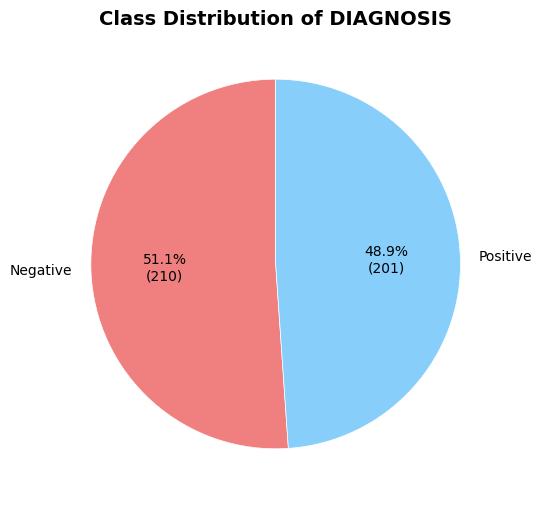

In [10]:
class_counts = y.value_counts()
labels = ['Negative', 'Positive']

def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count:d})'
    return inner_autopct

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels, autopct=autopct_format(class_counts), startangle=90, 
        colors=['lightcoral', 'lightskyblue'], wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})

plt.title('Class Distribution of DIAGNOSIS', fontsize=14, fontweight='bold')

plt.show()

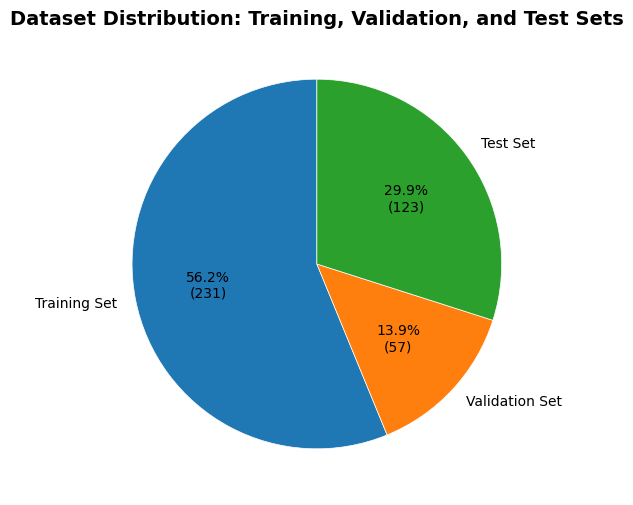

In [11]:
total_records = 411

test_percentage = 0.3
validation_percentage = 0.2  

test_count = int(total_records * test_percentage)
train_val_count = total_records - test_count
validation_count = int(train_val_count * validation_percentage)
train_count = train_val_count - validation_count

subset_counts = [train_count, validation_count, test_count]
labels = ['Training Set', 'Validation Set', 'Test Set']

def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count:d})'
    return inner_autopct

colors = plt.cm.tab10.colors[:3]  
plt.figure(figsize=(6, 6))
plt.pie(subset_counts, labels=labels, autopct=autopct_format(subset_counts), startangle=90,
        colors=colors, wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})

plt.title('Dataset Distribution: Training, Validation, and Test Sets', fontsize=14, fontweight='bold')
plt.show()


In [12]:
X.columns

Index(['Age', 'Clarity', 'Color', 'Transparency', 'Spec Gravity', 'pH Level',
       'Leukocytes', 'Nitrite', 'Protein', 'Glucose', 'Ketones',
       'Urobilinogen', 'Bilirubin', 'Blood', 'Bacteria', 'Epithelial Cells',
       'RBC', 'WBC', 'Mucus Threads', 'Amorphous Urate/Phosphate',
       'Marital Status_MARRIED', 'Marital Status_SINGLE',
       'Marital Status_WIDOW', 'FEMALE', 'FILIPINO'],
      dtype='object')

In [13]:
def show_study_summary(study: optuna.study.Study) -> None:
    print("\033[1mBest Hyperparameters")
    pprint(study.best_params)
    print()

    print("\033[1mAccuracy for the Best Hyperparameters")
    print(study.best_value)

    optimization_history_plot = optuna.visualization.plot_optimization_history(study)
    param_importances_plot = optuna.visualization.plot_param_importances(study)


    optimization_history_plot.update_layout({"height": 600})
    param_importances_plot.update_layout({"height": 600})


    optimization_history_plot.show()
    param_importances_plot.show()


## Logistic Regression

In [14]:
def logreg_objective(trial: optuna.study.Study) -> float:
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1),
    }

    LOGREG = LogisticRegression(**PARAMS, max_iter=2000, random_state=42)

    LOGREG.fit(X_train_scaled , y_train)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG.predict_proba(X_val_scaled )]

    F1_SCORE_ = f1_score(y_val , YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)


LOGREG_STUDY = optuna.create_study(direction="maximize", study_name="logreg_tuning", sampler=SAMPLER)

LOGREG_STUDY.optimize(logreg_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-24 22:41:24,194] A new study created in memory with name: logreg_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-24 22:41:24,308] Trial 2 finished with value: 0.9206349206349206 and parameters: {'tol': 0.00510532453753499, 'C': 0.9027085815793713, 'threshold': 0.17540237160450373}. Best is trial 2 with value: 0.9206349206349206.
[I 2024-11-24 22:41:24,351] Trial 10 finished with value: 0.6666666666666666 and parameters: {'tol': 0.006953314335013636, 'C': 0.19080740163545268, 'threshold': 0.9681766602907559}. Best is trial 2 with value: 0.9206349206349206.
[I 2024-11-24 22:41:24,359] Trial 3 finished with value: 0.9830508474576272 and parameters: {'tol': 3.986615897356878e-05, 'C': 0.17670507577769046, 'threshold': 0.27173375908992936}. Best is trial 3 with value: 0.9830508474576272.
[I 2024-11-24 22:41:24,374] Trial 0 finished with value: 0.9354838709677419 and parameters: {'tol': 0.00018830752984337176, 'C': 0.39032770948049533, 'threshold': 0.21332515608934188}. Best is trial 3 with value: 0.9830508474576272.
[I 2024-11-24 22:41:24,381] Trial 8 finished with value: 0.9830508474576272

In [15]:
show_study_summary(LOGREG_STUDY)

Best Hyperparameters
{'C': 0.13895476724746986,
 'threshold': 0.26515321127470093,
 'tol': 0.00039369158398199297}

Accuracy for the Best Hyperparameters
0.9836065573770492


## Support Vector Machine

In [16]:
def SVC_objective(trial: optuna.study.Study) -> float:
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 10, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL = SVC(**PARAMS, probability=True, random_state=42)

    SVC_MODEL.fit(X_train_scaled, y_train)

    YHAT = SVC_MODEL.predict(X_val_scaled)

    F1_SCORE_ = f1_score(y_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

SVM_SVC_STUDY = optuna.create_study(direction="maximize", study_name="SVM_tuning", sampler=SAMPLER)

SVM_SVC_STUDY.optimize(SVC_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-24 22:41:31,889] A new study created in memory with name: SVM_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-24 22:41:31,941] Trial 1 finished with value: 0.9473684210526315 and parameters: {'C': 0.19708253279084642, 'kernel': 'linear'}. Best is trial 1 with value: 0.9473684210526315.
[I 2024-11-24 22:41:31,949] Trial 2 finished with value: 0.8148148148148148 and parameters: {'C': 5.985117245727416, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.9473684210526315.
[I 2024-11-24 22:41:31,952] Trial 0 finished with value: 0.8148148148148148 and parameters: {'C': 5.616337986971785, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.9473684210526315.
[I 2024-11-24 22:41:31,968] Trial 3 finished with value: 0.8679245283018868 and parameters: {'C': 0.875222061635083, 'kernel': 'poly'}. Best is trial 1 with value: 0.9473684210526315.
[I 2024-11-24 22:41:31,978] Trial 5 finished with value: 0.9491525423728814 and parameters: {'C': 0.18188719077386137, 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9491525423728814.
[I 2024-11-24 22:41:31,979] Trial 4 finished with value: 0.949152

In [17]:
show_study_summary(SVM_SVC_STUDY)

Best Hyperparameters
{'C': 1.052982238195965, 'kernel': 'rbf'}

Accuracy for the Best Hyperparameters
0.9830508474576272


## XGBoost


In [18]:
def XGB_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }

    XGB_model = xgb.XGBClassifier(**PARAMS, random_state=42)

    XGB_model.fit(X_train, y_train)

    YHAT = XGB_model.predict(X_val)

    F1_SCORE_ = f1_score(y_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

XGB_STUDY = optuna.create_study(direction="maximize", study_name="XGB_tuning", sampler=SAMPLER)

XGB_STUDY.optimize(XGB_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-24 22:41:36,028] A new study created in memory with name: XGB_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-24 22:41:36,632] Trial 1 finished with value: 0.9508196721311475 and parameters: {'reg_alpha': 0.4022968842782686, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.0010054280735921218, 'subsample': 0.5430509945393048, 'colsample_bytree': 0.722322394853441}. Best is trial 1 with value: 0.9508196721311475.
[I 2024-11-24 22:41:36,842] Trial 10 finished with value: 0.9491525423728814 and parameters: {'reg_alpha': 0.5057143081115097, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.002264961446348862, 'subsample': 0.98554689624172, 'colsample_bytree': 0.9713057008041115}. Best is trial 1 with value: 0.9508196721311475.
[I 2024-11-24 22:41:37,068] Trial 6 finished with value: 0.9830508474576272 and parameters: {'reg_alpha': 0.5534163778169158, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0026596462570413672, 'subsample': 0.66973732760769, 'colsample_bytree': 0.8204270209059041}. Best is trial 6 with value: 0.9830508474576272.
[I 2024-11-24 22:41:37,180] T

In [19]:
show_study_summary(XGB_STUDY)

Best Hyperparameters
{'colsample_bytree': 0.8204270209059041,
 'learning_rate': 0.0026596462570413672,
 'max_depth': 5,
 'n_estimators': 250,
 'reg_alpha': 0.5534163778169158,
 'subsample': 0.66973732760769}

Accuracy for the Best Hyperparameters
0.9830508474576272


## LGBM

In [20]:
def lightgbm_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }
    
    LGMB_MODEL = lgb.LGBMClassifier(**PARAMS, random_state=42)
    
    LGMB_MODEL.fit(X_train, y_train) 
    
    YHAT = LGMB_MODEL.predict(X_val)
    
    F1_SCORE_ = f1_score(y_val, YHAT)
    
    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LGBM_STUDY = optuna.create_study(direction="maximize", study_name="lgbm_tuning", sampler=SAMPLER)

LGBM_STUDY.optimize(lightgbm_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-24 22:42:12,802] A new study created in memory with name: lgbm_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-24 22:42:13,245] Trial 4 finished with value: 0.9830508474576272 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.07844995021757604, 'reg_alpha': 0.5764208302158135, 'subsample': 0.6578715526884154, 'colsample_bytree': 0.5086547007431199, 'min_child_samples': 66}. Best is trial 4 with value: 0.9830508474576272.
[I 2024-11-24 22:42:13,283] Trial 6 finished with value: 0.9830508474576272 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.01558390376783989, 'reg_alpha': 0.8499850791810807, 'subsample': 0.7733453051697685, 'colsample_bytree': 0.9509455275293397, 'min_child_samples': 86}. Best is trial 4 with value: 0.9830508474576272.
[I 2024-11-24 22:42:13,306] Trial 9 finished with value: 0.967741935483871 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.028586950621107804, 'reg_a

In [21]:
show_study_summary(LGBM_STUDY)

Best Hyperparameters
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.5129715264447415,
 'learning_rate': 0.05481486539824464,
 'max_depth': 5,
 'min_child_samples': 61,
 'n_estimators': 450,
 'num_leaves': 90,
 'reg_alpha': 0.374924792705995,
 'subsample': 0.689537661330387}

Accuracy for the Best Hyperparameters
0.9836065573770492


## TabNet

In [22]:
# np para tanggapin ni tabnet
X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

In [23]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns and their indices
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
numerical_indices = [X.columns.get_loc(col) for col in numerical_columns]

tab_scaler = StandardScaler()

# Fit the scaler on the numerical columns of the training data
X_train_np[:, numerical_indices] = tab_scaler.fit_transform(X_train_np[:, numerical_indices])

# Transform the numerical columns of the validation and test data
X_val_np[:, numerical_indices] = tab_scaler.transform(X_val_np[:, numerical_indices])
X_test_np[:, numerical_indices] = tab_scaler.transform(X_test_np[:, numerical_indices])


In [24]:
# Optuna Objective Function
def tabnet_objective(trial: optuna.study.Study) -> float:
    # Hyperparameters to tune
    n_d = trial.suggest_int("n_d", 8, 32, step=8)
    n_a = trial.suggest_int("n_a", 8, 32, step=8)
    n_steps = trial.suggest_int("n_steps", 3, 6)
    gamma = trial.suggest_float("gamma", 1.0, 1.5, step=0.1)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True)
    lr = trial.suggest_float("lr", 1e-3, 5e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 256, 1024, step=128)

    # Initialize TabNet with the trial's hyperparameters
    tabnet_model = TabNetClassifier(
        n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma,
        lambda_sparse=lambda_sparse, optimizer_params=dict(lr=lr), seed=42
    )


    # Train the model
    tabnet_model.fit(
        X_train=X_train_np, 
        y_train=y_train_np,
        eval_set=[(X_train_np, y_train_np), (X_val_np, y_val_np)],
        eval_name=["train", "val"],
        eval_metric=["accuracy"],  
        max_epochs=100,
        patience=5,
        batch_size=batch_size,
        virtual_batch_size=batch_size // 2,
        num_workers=0,
        drop_last=False,
    )

    # Get validation F1 score
    YHAT = tabnet_model.predict(X_val_np)
    f1 = recall_score(y_val_np, YHAT)
    return f1 

# Run Optuna optimization
tabnet_study = optuna.create_study(direction="maximize", study_name="tabnet_tuning")
tabnet_study.optimize(tabnet_objective, n_trials=100, show_progress_bar=True)


[I 2024-11-24 22:42:34,602] A new study created in memory with name: tabnet_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0  | loss: 1.14111 | train_accuracy: 0.48035 | val_accuracy: 0.37931 |  0:00:00s
epoch 1  | loss: 0.84718 | train_accuracy: 0.49345 | val_accuracy: 0.51724 |  0:00:00s
epoch 2  | loss: 0.75188 | train_accuracy: 0.49782 | val_accuracy: 0.51724 |  0:00:00s
epoch 3  | loss: 0.67975 | train_accuracy: 0.47598 | val_accuracy: 0.53448 |  0:00:00s
epoch 4  | loss: 0.69409 | train_accuracy: 0.48908 | val_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.58697 | train_accuracy: 0.54585 | val_accuracy: 0.7069  |  0:00:00s
epoch 6  | loss: 0.58016 | train_accuracy: 0.70742 | val_accuracy: 0.82759 |  0:00:00s
epoch 7  | loss: 0.50952 | train_accuracy: 0.80786 | val_accuracy: 0.89655 |  0:00:00s
epoch 8  | loss: 0.41679 | train_accuracy: 0.81223 | val_accuracy: 0.87931 |  0:00:00s
epoch 9  | loss: 0.47797 | train_accuracy: 0.85153 | val_accuracy: 0.91379 |  0:00:00s
epoch 10 | loss: 0.42943 | train_accuracy: 0.84279 | val_accuracy: 0.89655 |  0:00:00s
epoch 11 | loss: 0.44096 | train_accuracy: 

In [25]:
show_study_summary(tabnet_study)

Best Hyperparameters
{'batch_size': 1024,
 'gamma': 1.1,
 'lambda_sparse': 0.0003462871350902527,
 'lr': 0.0011065001912358315,
 'n_a': 16,
 'n_d': 8,
 'n_steps': 4}

Accuracy for the Best Hyperparameters
1.0


In [26]:
from typing import Union, Tuple
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def test_model(
        models: list,
        params: dict,
        X_train: Union[np.ndarray, pd.DataFrame],
        y_train: Union[np.ndarray, pd.Series],
        X_test: Union[np.ndarray, pd.DataFrame],
        y_test: Union[np.ndarray, pd.Series],
        X_train_scaled: Union[np.ndarray, pd.DataFrame],
        X_test_scaled: Union[np.ndarray, pd.DataFrame]
    ) -> Tuple[dict, pd.DataFrame]:

    model_testing_scores = pd.DataFrame()
    models_container = {}

    model_testing_scores["Model"] = []
    model_testing_scores["Accuracy"] = []
    model_testing_scores["Precision"] = []
    model_testing_scores["Recall"] = []
    model_testing_scores["F1-Score"] = []
    model_testing_scores["Specificity"] = []
    model_testing_scores["AUC-ROC"] = []

    for model in tqdm(models):
        MODEL_NAME = model().__class__.__name__
        MODEL_KEY = MODEL_NAME + "_R" if (MODEL_NAME + "_R") in params else MODEL_NAME

        # Decide which data to use (scaled or unscaled)
        if MODEL_KEY in ["XGBClassifier", "LGBMClassifier"]:
            X_train_input, X_test_input = X_train, X_test  # Use unscaled data
        else:
            X_train_input, X_test_input = X_train_scaled, X_test_scaled  # Use scaled data

        # Check if model is Logistic Regression with a threshold
        if MODEL_KEY == "LogisticRegression_R" or MODEL_KEY == "LogisticRegression":
            test_model = model(tol=params[MODEL_KEY]["tol"],
                               C=params[MODEL_KEY]["C"],
                               max_iter=2000)
            test_model.fit(X_train_input, y_train)

            # Apply custom threshold
            test_pred = [1 if proba[1] > params[MODEL_KEY]["threshold"] else 0 for proba in
                         test_model.predict_proba(X_test_input)]

        # Check if model is TabNetClassifier
        elif MODEL_KEY == "TabNetClassifierx":
            # Convert to numpy arrays if they are DataFrames for TabNet compatibility
            X_train_input = X_train_input.values if isinstance(X_train_input, pd.DataFrame) else X_train_input
            X_test_input = X_test_input.values if isinstance(X_test_input, pd.DataFrame) else X_test_input

            test_model = model(**params[MODEL_KEY])
            test_model.fit(X_train_input, y_train)  # Use numpy array
            test_pred = test_model.predict(X_test_input)  # Use numpy array

        # For all other models
        else:
            test_model = model(**params[MODEL_KEY])
            test_model.fit(X_train_input, y_train)
            test_pred = test_model.predict(X_test_input)

        # Calculate metrics
        TN, FP, _, _ = confusion_matrix(y_test, test_pred).ravel()
        TESTING_SPECIFICITY = TN / (TN + FP)

        # Append results to the DataFrame
        model_testing_scores = model_testing_scores._append({
            "Model": MODEL_KEY,
            "Accuracy": accuracy_score(y_test, test_pred),
            "Precision": precision_score(y_test, test_pred),
            "Recall": recall_score(y_test, test_pred),
            "F1-Score": f1_score(y_test, test_pred),
            "Specificity": TESTING_SPECIFICITY,
            "AUC-ROC": roc_auc_score(y_test, test_pred)
        }, ignore_index=True)

        # Store the trained model in the container
        models_container[MODEL_KEY] = test_model

    return models_container, model_testing_scores


In [27]:

tabnet_model = TabNetClassifier(
    n_d=8,
    n_a=16,
    n_steps=4,
    gamma=1.1,
    lambda_sparse=0.0008996258460280748,
    optimizer_params=dict(lr=0.004574041939890459),
    seed=42
)


# metrics_logger = MetricsLogger(tabnet_model, X_train_np, y_train_np, X_val_np, y_val_np)

tabnet_model.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_val_np, y_val_np)],
    eval_name=["train", "val"],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=15,
    batch_size=256,
    virtual_batch_size=256 // 2,
    num_workers=0,
    drop_last=False,
)

epoch 0  | loss: 1.35851 | train_accuracy: 0.50655 | val_accuracy: 0.51724 |  0:00:00s
epoch 1  | loss: 1.221   | train_accuracy: 0.51092 | val_accuracy: 0.51724 |  0:00:00s
epoch 2  | loss: 1.1915  | train_accuracy: 0.51528 | val_accuracy: 0.51724 |  0:00:00s
epoch 3  | loss: 1.04424 | train_accuracy: 0.51528 | val_accuracy: 0.51724 |  0:00:00s
epoch 4  | loss: 1.02669 | train_accuracy: 0.51965 | val_accuracy: 0.51724 |  0:00:00s
epoch 5  | loss: 0.99114 | train_accuracy: 0.51092 | val_accuracy: 0.51724 |  0:00:00s
epoch 6  | loss: 0.90753 | train_accuracy: 0.51965 | val_accuracy: 0.53448 |  0:00:00s
epoch 7  | loss: 0.81385 | train_accuracy: 0.54585 | val_accuracy: 0.53448 |  0:00:00s
epoch 8  | loss: 0.81919 | train_accuracy: 0.54585 | val_accuracy: 0.56897 |  0:00:00s
epoch 9  | loss: 0.76133 | train_accuracy: 0.53712 | val_accuracy: 0.55172 |  0:00:00s
epoch 10 | loss: 0.70504 | train_accuracy: 0.54585 | val_accuracy: 0.62069 |  0:00:00s
epoch 11 | loss: 0.6966  | train_accuracy: 

In [28]:
tab_test_pred = tabnet_model.predict(X_test_np)
# Initialize the results DataFrame
tab_test_scores = pd.DataFrame(columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "AUC-ROC"
])

# Calculate confusion matrix and specificity
TN, FP, FN, TP = confusion_matrix(y_test_np, tab_test_pred).ravel()
TESTING_SPECIFICITY = TN / (TN + FP)

# Append results to the DataFrame
tab_test_scores = tab_test_scores._append({
    "Model": "TabNetClassifier",
    "Accuracy": accuracy_score(y_test_np, tab_test_pred),
    "Precision": precision_score(y_test_np, tab_test_pred),
    "Recall": recall_score(y_test_np, tab_test_pred),
    "F1-Score": f1_score(y_test_np, tab_test_pred),
    "Specificity": TESTING_SPECIFICITY,
    "AUC-ROC": roc_auc_score(y_test_np, tab_test_pred)
}, ignore_index=True)

tab_test_scores

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  TabNetClassifier  0.830645       0.92  0.730159  0.814159     0.934426   

    AUC-ROC  
0  0.832292

In [29]:

LIST_OF_MODELS = [LogisticRegression, SVC, xgb.XGBClassifier, lgb.LGBMClassifier]

MODELS_PARAMETERS = {
    "LogisticRegression": {
        'C': 0.4453875363488851,
        'threshold': 0.22236207331992044,
        'tol': 0.00013402013597938053
    },
    "SVC": {
        'C': 1.5539518731748816, 'kernel': 'linear', 'probability': True
    },
    "XGBClassifier": {
        'colsample_bytree': 0.8185893721460695,
        'learning_rate': 0.02058418254468569,
        'max_depth': 14,
        'n_estimators': 450,
        'reg_alpha': 0.7174529376089127,
        'subsample': 0.523767606850942
    },
    "LGBMClassifier": {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        'boosting_type': 'gbdt',
        'colsample_bytree': 0.6849848976147105,
        'learning_rate': 0.035926357120152796,
        'max_depth': -1,
        'min_child_samples': 40,
        'n_estimators': 250,
        'num_leaves': 50,
        'reg_alpha': 0.22504432029041724,
        'subsample': 0.7289410221969029
    }
}

MODEL_CONTAINER, TESTING_SCORES = test_model(
    models=LIST_OF_MODELS,
    params=MODELS_PARAMETERS,
    X_train=X_train,  # Unscaled
    y_train=y_train,
    X_test=X_test,  # Unscaled
    y_test=y_test,
    X_train_scaled=X_train_scaled,  # Scaled
    X_test_scaled=X_test_scaled  # Scaled
)


TESTING_SCORES


100%|██████████| 4/4 [00:00<00:00, 11.44it/s]


Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC  0.935484   0.936508  0.936508  0.936508     0.934426   
2       XGBClassifier  0.959677   0.953125  0.968254  0.960630     0.950820   
3      LGBMClassifier  0.927419   0.950000  0.904762  0.926829     0.950820   

    AUC-ROC  
0  0.942883  
1  0.935467  
2  0.959537  
3  0.927791

In [30]:
MODEL_CONTAINER["TabNetClassifier"] = tabnet_model

In [31]:
def display_confusion_matrices(model_container, X_test, X_test_scaled, X_test_np, y_test, threshold=0.5):
    for name, model in model_container.items():
        # Decide which test data to use
        if "XGB" in name or "LGBM" in name:
            X_input = X_test  
        elif "TabNet" in name:
            X_input = X_test_np
        else:
            X_input = X_test_scaled  

        # Make predictions with threshold for Logistic Regression
        if "LogisticRegression" in name:
            # Get probabilities and apply threshold
            y_pred = (model.predict_proba(X_input)[:, 1] >= threshold).astype(int)
        else:
            # Default prediction method for other models
            y_pred = model.predict(X_input)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("True Label")
        plt.ylabel("Predicted Label")
        plt.show()


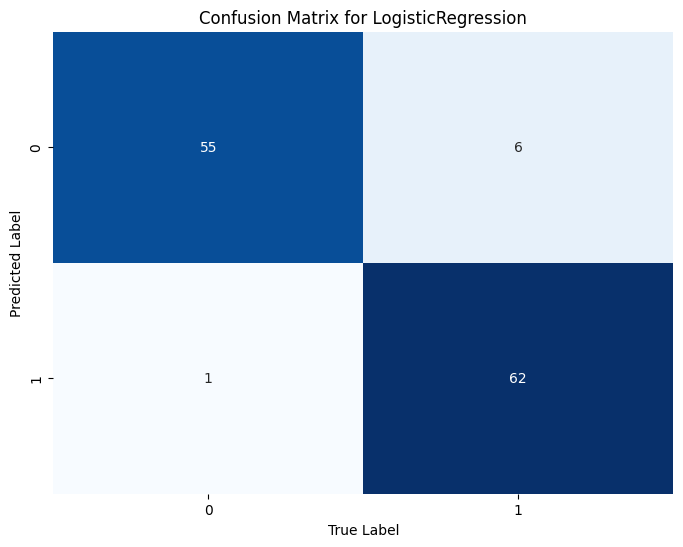

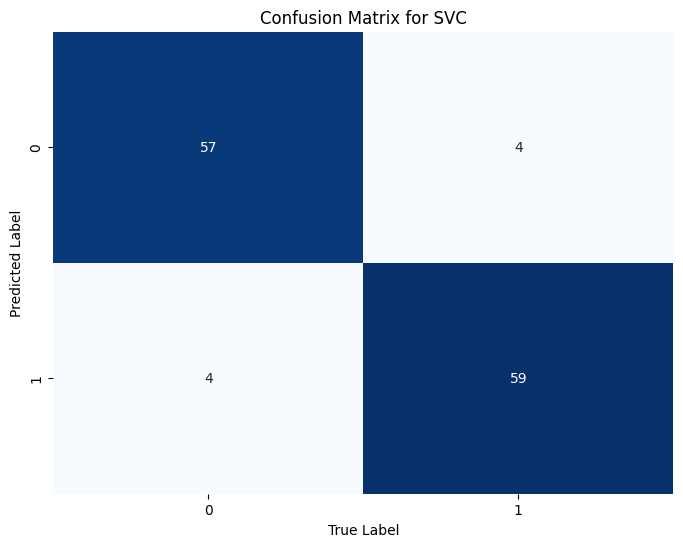

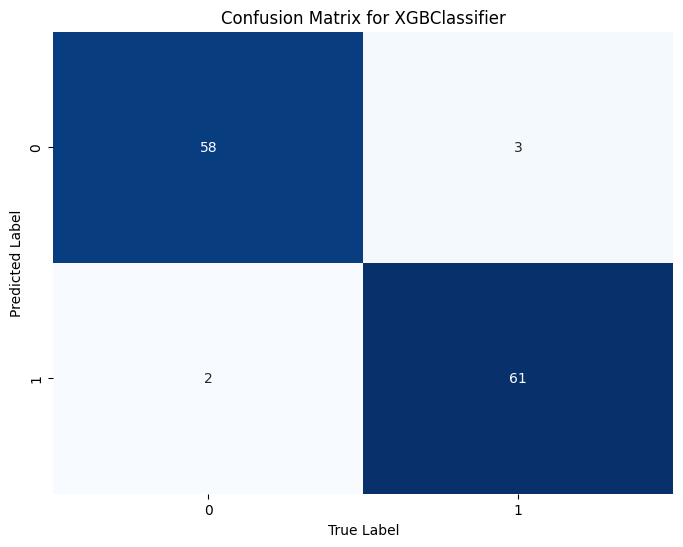

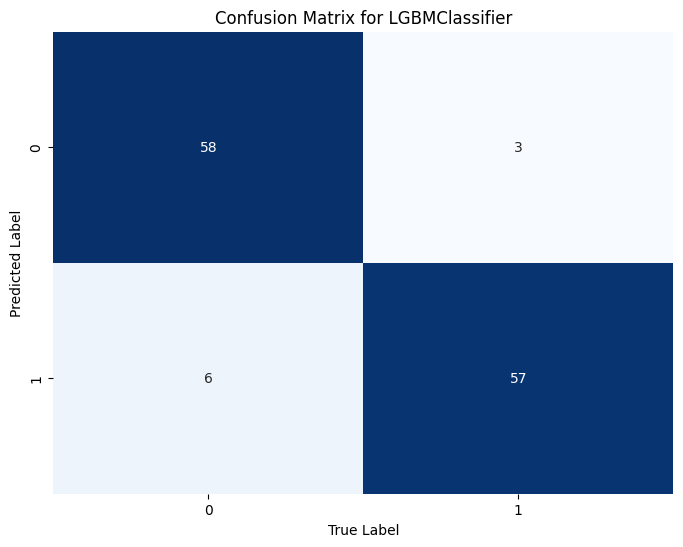

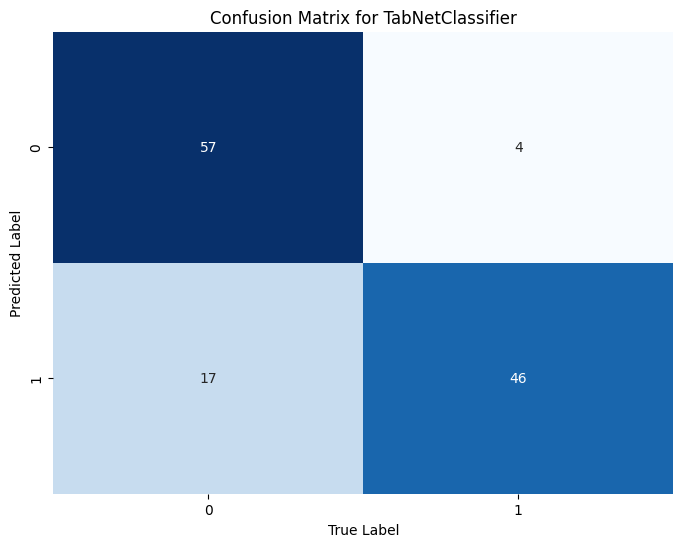

In [32]:
display_confusion_matrices(MODEL_CONTAINER, X_test, X_test_scaled, X_test_np, y_test, threshold=0.22236207331992044)

In [33]:
TESTING_SCORES = TESTING_SCORES._append(tab_test_scores, ignore_index=True)
TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC  0.935484   0.936508  0.936508  0.936508     0.934426   
2       XGBClassifier  0.959677   0.953125  0.968254  0.960630     0.950820   
3      LGBMClassifier  0.927419   0.950000  0.904762  0.926829     0.950820   
4    TabNetClassifier  0.830645   0.920000  0.730159  0.814159     0.934426   

    AUC-ROC  
0  0.942883  
1  0.935467  
2  0.959537  
3  0.927791  
4  0.832292

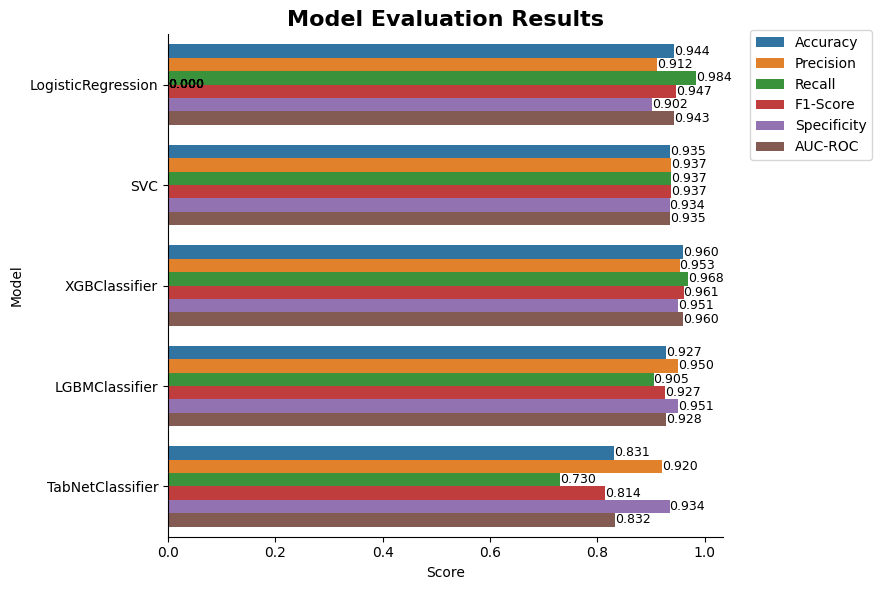

In [34]:
# Prepare data for plotting
plot_df = pd.melt(TESTING_SCORES, id_vars=["Model"])
plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)

PLOT = sns.catplot(
    x="Score", 
    y="Model", 
    hue="Metric", 
    data=plot_df, 
    kind="bar", 
    orient="h",
    height=6, 
    aspect=1.5, 
    legend_out=False,
    palette="tab10"  
)

# Access the axes of the plot
ax = PLOT.axes[0, 0]

# Annotate the bars with their corresponding scores
for p in ax.patches:
    ax.annotate(f"{p.get_width():.3f}", 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left", va="center", fontsize=9)

# Set plot title and legend
plt.title("Model Evaluation Results", fontsize=16, fontweight='bold')
plt.legend(loc=(1.05, 0.75))
plt.tight_layout()

# Display the plot
plt.show()


In [35]:
def plot_feature_importances(model, X_columns, title, top_n=20):

    # Extract and sort feature importances
    results = {column: value for value, column in zip(model.feature_importances_, X_columns)}
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)[:top_n]  # Top N features

    # Separate names and values for the top features
    feature_names, importances = zip(*sorted_results)

    plt.figure(figsize=(14, 8))  
    plt.barh(range(len(importances)), importances, align='center', color="lightblue")
    plt.yticks(range(len(feature_names)), [name[:15] + '...' if len(name) > 15 else name for name in feature_names], fontsize=9)

    # Set titles and labels
    plt.title(f"{title}: Top {top_n} Feature Importance", fontsize=14, fontweight='bold')
    plt.xlabel("Feature importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.ylim(-1, top_n)
    plt.gca().invert_yaxis()  
    plt.show()



In [36]:
TRAINED_XGB = MODEL_CONTAINER["XGBClassifier"]
TRAINED_LGBM = MODEL_CONTAINER["LGBMClassifier"]
TRAINED_SVM = MODEL_CONTAINER["SVC"]
TRAINED_LOGREG = MODEL_CONTAINER["LogisticRegression"]
TRAINED_TABNET = MODEL_CONTAINER["TabNetClassifier"]

In [37]:
y_pred_logreg = TRAINED_LOGREG.predict(X_test_scaled)

## FEATURE IMPORTANCE AND SHAP

In [38]:
import matplotlib.pyplot as plt

def plot_model_feature_importance(model, feature_names):

    feature_importances = model.feature_importances_
    
    sorted_indices = feature_importances.argsort()[::-1]
    sorted_feature_importances = feature_importances[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]

    model_name = type(model).__name__
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_feature_names, sorted_feature_importances)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"{model_name} Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()


In [39]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X, y, feature_names, scoring='f1'):

    # Calculate permutation importance
    result = permutation_importance(model, X, y, scoring=scoring)

    # Extract and sort importance values
    importances = result.importances_mean
    sorted_indices = importances.argsort()[::-1]
    sorted_importances = importances[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_feature_names, sorted_importances)
    plt.xlabel("Mean Permutation Importance")
    plt.ylabel("Feature")
    plt.title(f"Permutation Importance for {type(model).__name__}")
    plt.gca().invert_yaxis()
    plt.show()

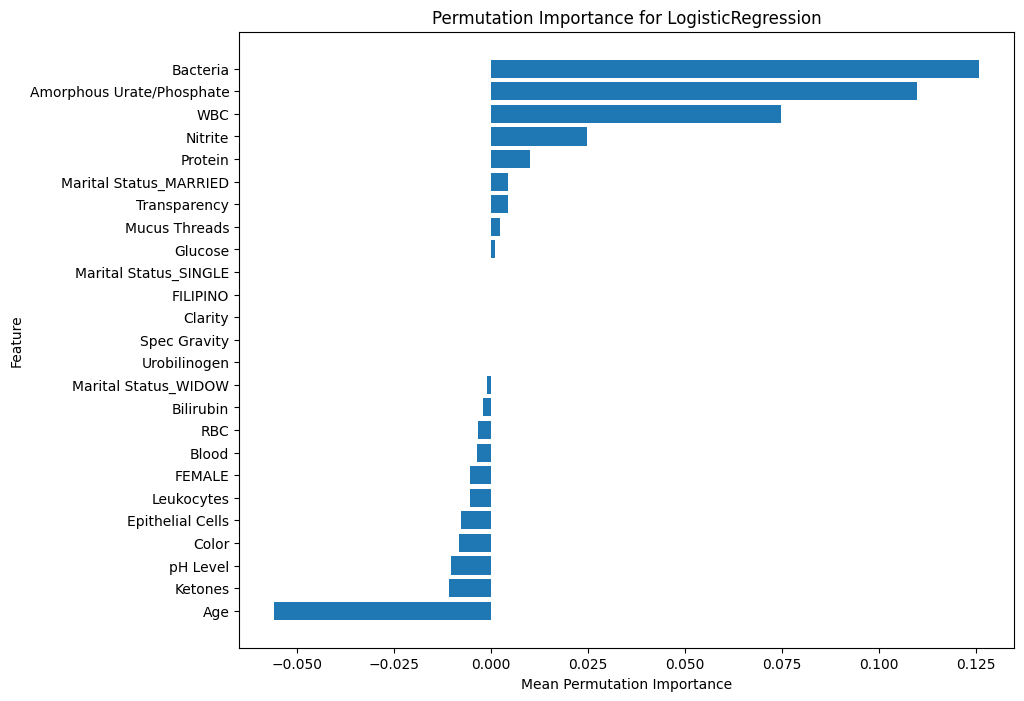

In [40]:
plot_permutation_importance(TRAINED_LOGREG, X, y, X.columns, scoring='f1')

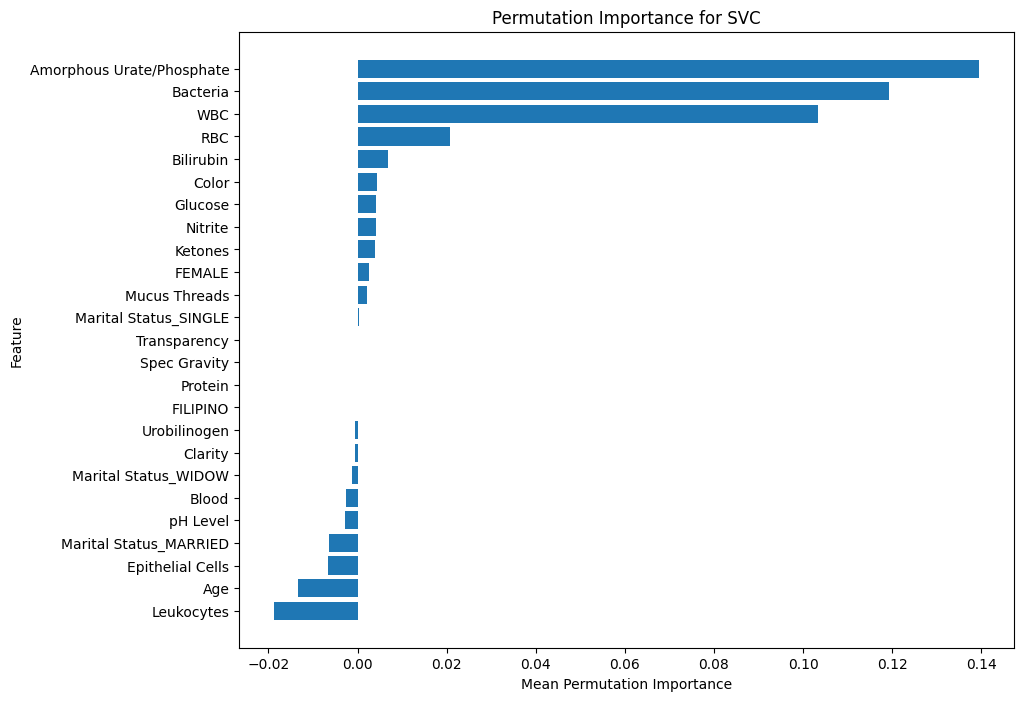

In [41]:
plot_permutation_importance(TRAINED_SVM, X, y, X.columns, scoring='f1')

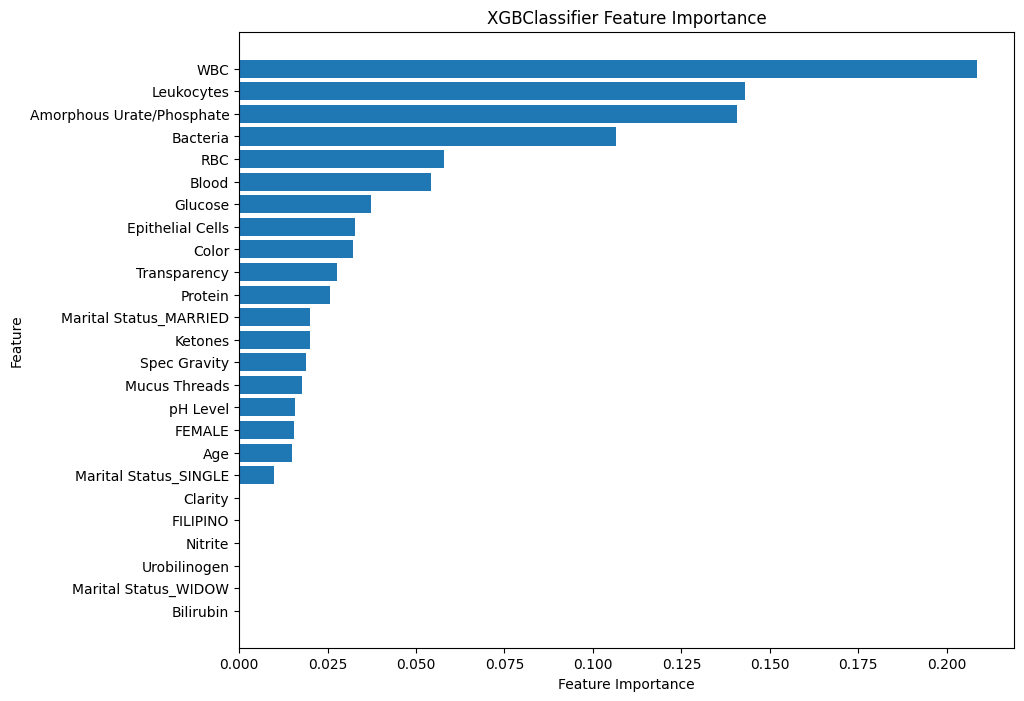

In [42]:
plot_model_feature_importance(TRAINED_XGB, X.columns)

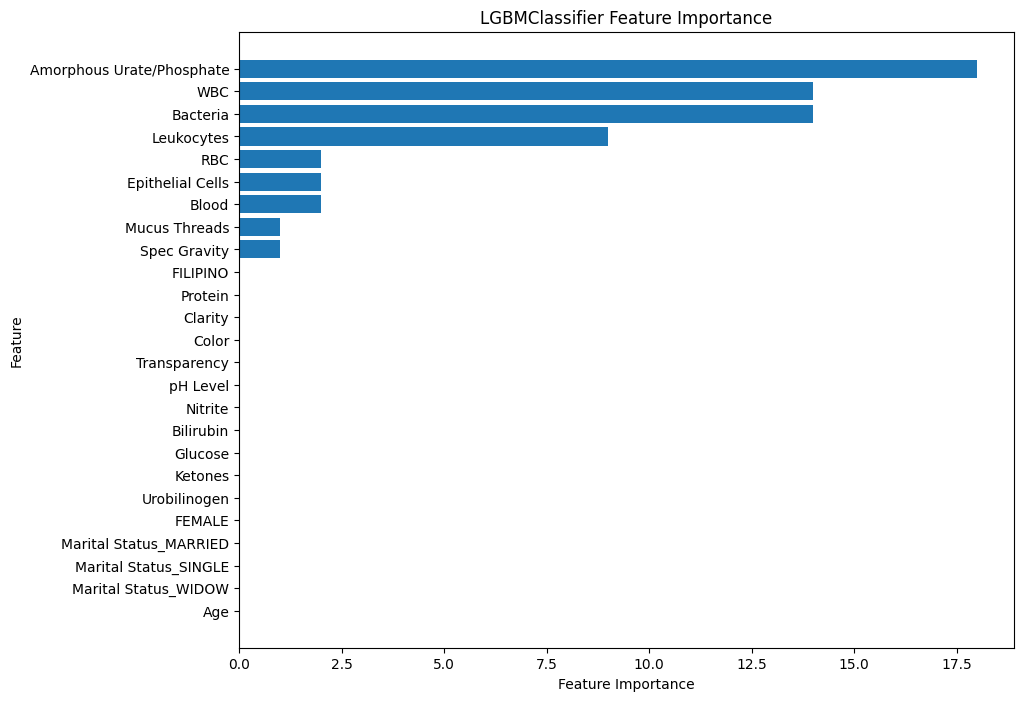

In [43]:
plot_model_feature_importance(TRAINED_LGBM, X.columns)

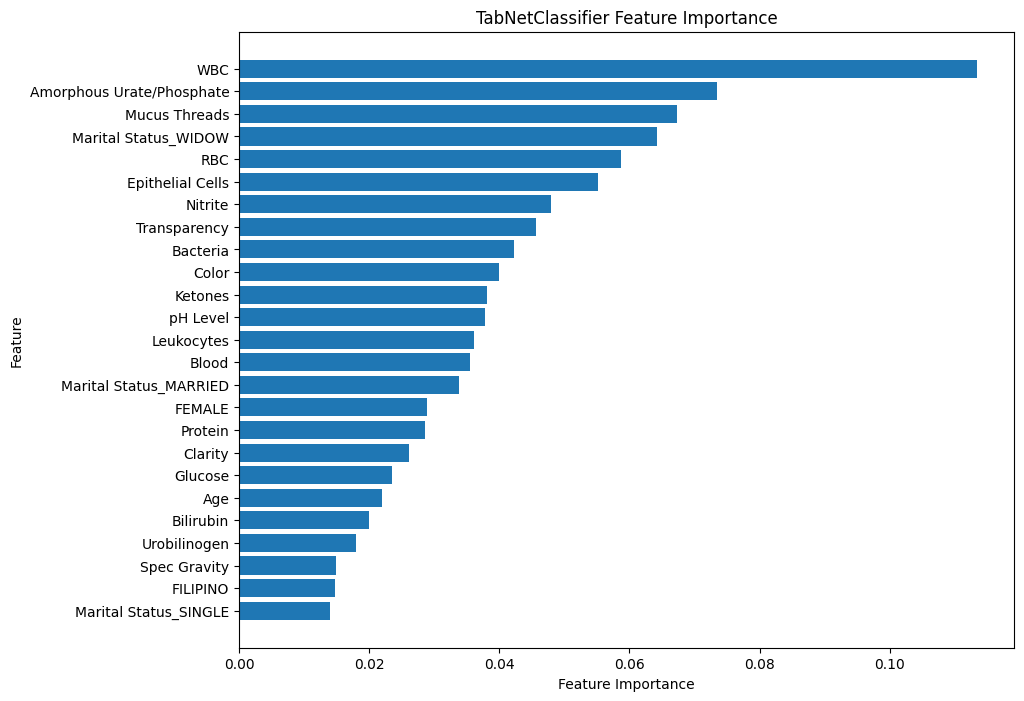

In [44]:
plot_model_feature_importance(TRAINED_TABNET, X.columns)

## XGB SHAP

In [45]:
XGB_EXPLAINER = shap.TreeExplainer(TRAINED_XGB, X_test)

XGB_SHAP_VALUES = XGB_EXPLAINER.shap_values(X_test, check_additivity=False)

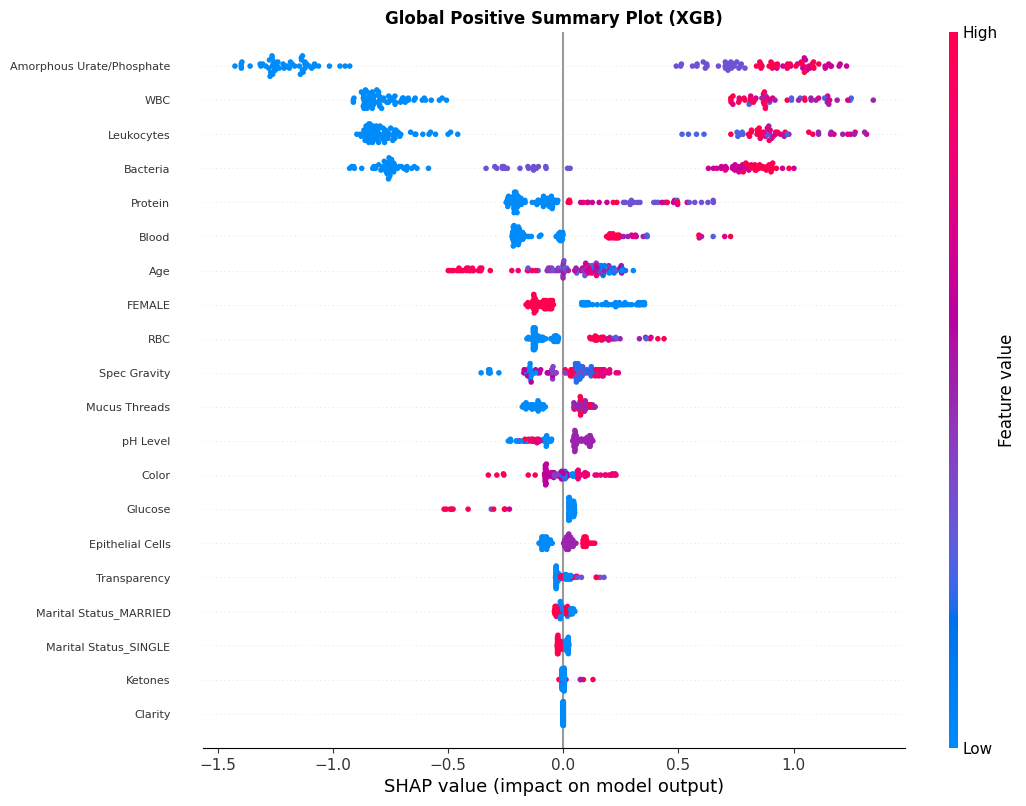

In [46]:
# SHAP Global Positive Summary Plot
plt.figure(figsize=(12, 8)) 
shap.summary_plot(
    XGB_SHAP_VALUES,
    X_test,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),  
)
plt.title("Global Positive Summary Plot (XGB)", fontdict={"fontweight": "bold"})
plt.gca().tick_params(axis='y', labelsize=8) 
plt.show()

## LGB SHAP

In [47]:
LGBM_EXPLAINER = shap.TreeExplainer(TRAINED_LGBM, X_test)

LGBM_SHAP_VALUES = LGBM_EXPLAINER.shap_values(X_test, check_additivity=False)

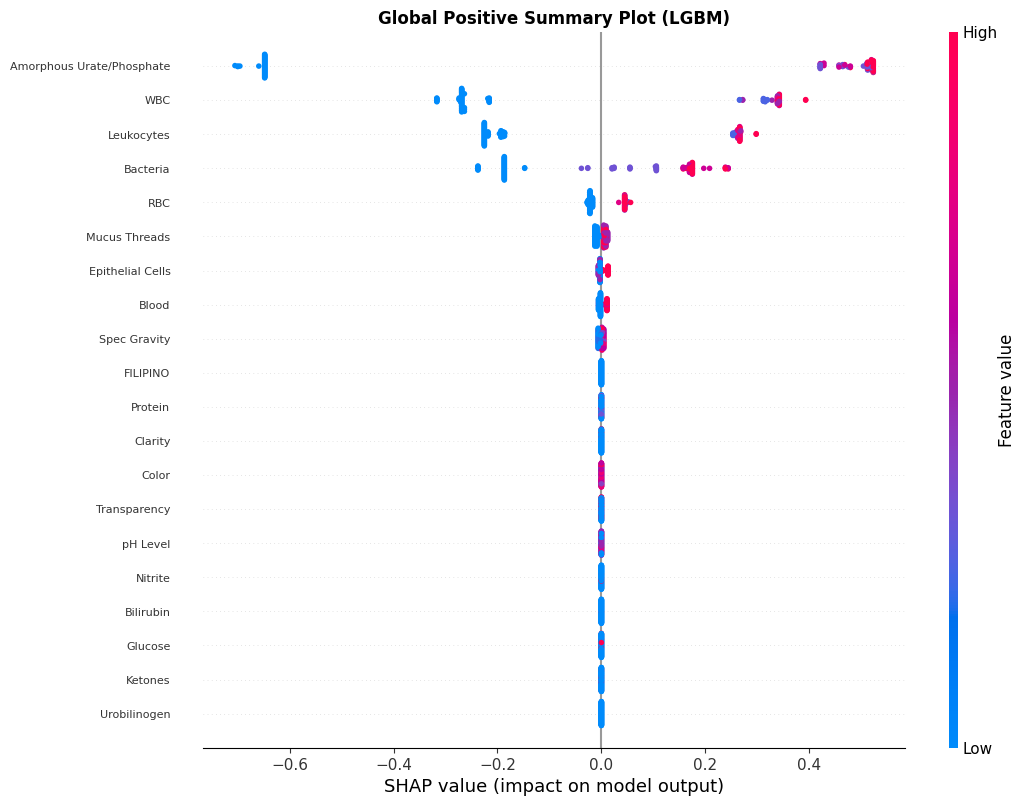

In [48]:
# SHAP Global Positive Summary Plot
plt.figure(figsize=(12, 8)) 
shap.summary_plot(
    LGBM_SHAP_VALUES,
    X_test,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),  
)
plt.title("Global Positive Summary Plot (LGBM)", fontdict={"fontweight": "bold"})
plt.gca().tick_params(axis='y', labelsize=8) 
plt.show()

## LOGREG SHAP

In [49]:
LOGREG_EXPLAINER = shap.LinearExplainer(TRAINED_LOGREG, X_test_scaled)

LOGREG_SHAP_VALUES = LOGREG_EXPLAINER.shap_values(X_test_scaled)

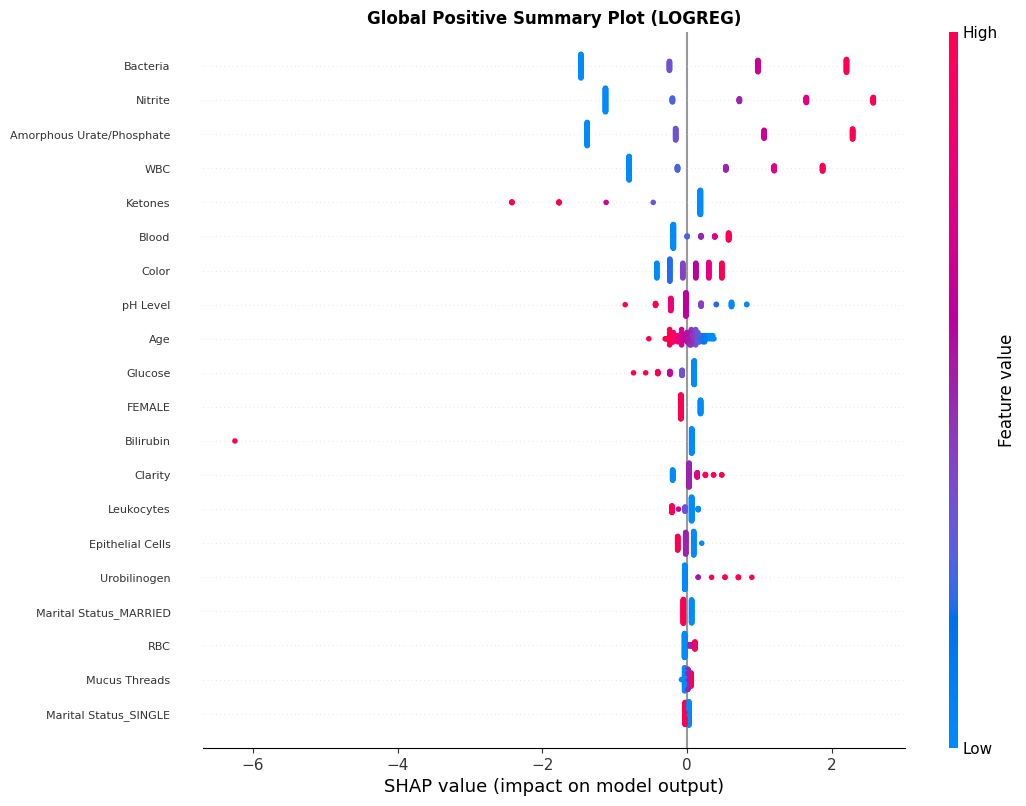

In [50]:
# SHAP Global Positive Summary Plot
plt.figure(figsize=(12, 8)) 
shap.summary_plot(
    LOGREG_SHAP_VALUES,
    X_test_scaled,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),  
)
plt.title("Global Positive Summary Plot (LOGREG)", fontdict={"fontweight": "bold"})
plt.gca().tick_params(axis='y', labelsize=8) 
plt.show()

## SVM SHAP

In [51]:
SVM_EXPLAINER = shap.LinearExplainer(TRAINED_SVM, X_test_scaled)

SVM_SHAP_VALUES = SVM_EXPLAINER.shap_values(X_test_scaled)

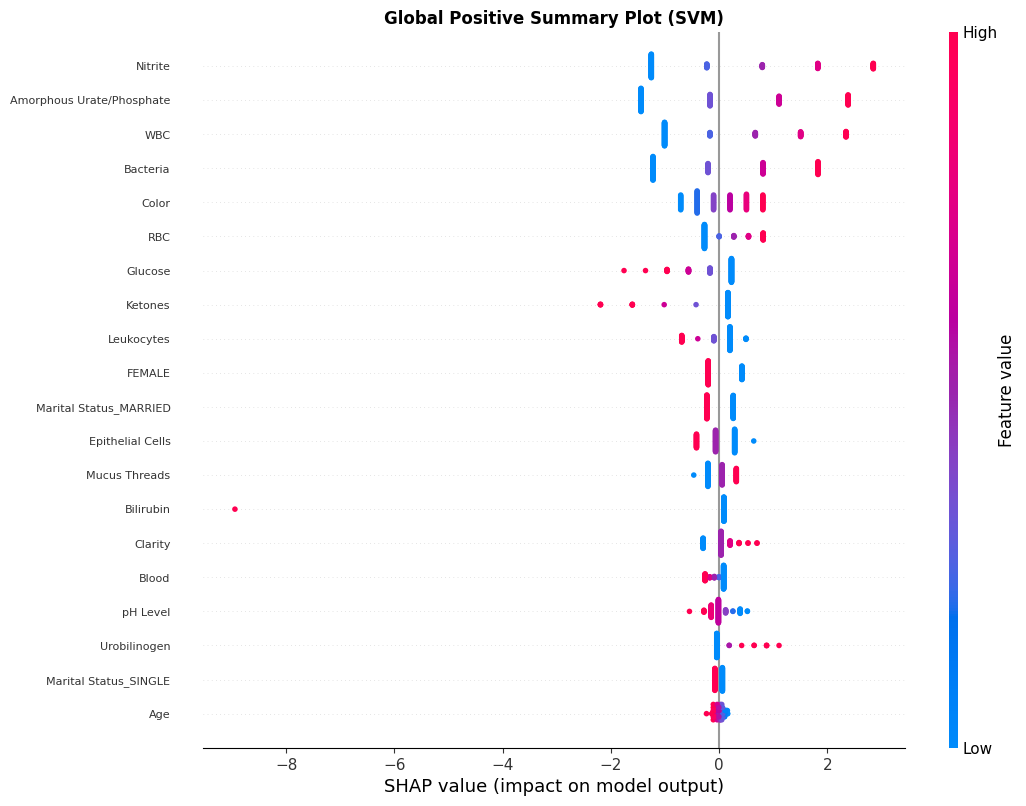

In [52]:
# SHAP Global Positive Summary Plot
plt.figure(figsize=(12, 8)) 
shap.summary_plot(
    SVM_SHAP_VALUES,
    X_test_scaled,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),  
)
plt.title("Global Positive Summary Plot (SVM)", fontdict={"fontweight": "bold"})
plt.gca().tick_params(axis='y', labelsize=8) 
plt.show()

In [53]:
import pandas as pd

def print_top_shap_features(shap_values, feature_names, model_name="Model", top_n=10):
 
    shap_values_df = pd.DataFrame(shap_values, columns=feature_names)

    shap_values_sum = shap_values_df.abs().mean(axis=0)

    top_features = shap_values_sum.sort_values(ascending=False).head(top_n)

    print(f"\nTop {top_n} Features for {model_name} based on SHAP values:")
    print(top_features.to_frame(name='Mean Absolute SHAP Value'))

    return np.array(top_features.index)


In [54]:
top_features_svm = print_top_shap_features(SVM_SHAP_VALUES, feature_names=X.columns, model_name="SVC", top_n=10)
top_features_svm


Top 10 Features for SVC based on SHAP values:
                           Mean Absolute SHAP Value
Nitrite                                    1.412793
Amorphous Urate/Phosphate                  1.296019
WBC                                        1.146645
Bacteria                                   1.111675
Color                                      0.452179
RBC                                        0.384042
Glucose                                    0.318732
Ketones                                    0.297141
Leukocytes                                 0.292575
FEMALE                                     0.280550


array(['Nitrite', 'Amorphous Urate/Phosphate', 'WBC', 'Bacteria', 'Color',
       'RBC', 'Glucose', 'Ketones', 'Leukocytes', 'FEMALE'], dtype=object)

In [55]:
top_features_lgbm = print_top_shap_features(LGBM_SHAP_VALUES, feature_names=X.columns, model_name="LGBMClassifier", top_n=10)
top_features_lgbm


Top 10 Features for LGBMClassifier based on SHAP values:
                           Mean Absolute SHAP Value
Amorphous Urate/Phosphate                  0.561961
WBC                                        0.296085
Leukocytes                                 0.235969
Bacteria                                   0.167803
RBC                                        0.029247
Mucus Threads                              0.008312
Epithelial Cells                           0.005406
Blood                                      0.004614
Spec Gravity                               0.002933
Age                                        0.000000


array(['Amorphous Urate/Phosphate', 'WBC', 'Leukocytes', 'Bacteria',
       'RBC', 'Mucus Threads', 'Epithelial Cells', 'Blood',
       'Spec Gravity', 'Age'], dtype=object)

In [56]:
top_features_xgb = print_top_shap_features(XGB_SHAP_VALUES, feature_names=X.columns, model_name="XGBClassifier", top_n=10)
top_features_xgb


Top 10 Features for XGBClassifier based on SHAP values:
                           Mean Absolute SHAP Value
Amorphous Urate/Phosphate                  1.023363
WBC                                        0.848629
Leukocytes                                 0.838040
Bacteria                                   0.687714
Protein                                    0.206698
Blood                                      0.205205
Age                                        0.177107
FEMALE                                     0.142191
RBC                                        0.134641
Spec Gravity                               0.116730


array(['Amorphous Urate/Phosphate', 'WBC', 'Leukocytes', 'Bacteria',
       'Protein', 'Blood', 'Age', 'FEMALE', 'RBC', 'Spec Gravity'],
      dtype=object)

In [57]:
top_features_logreg = print_top_shap_features(LOGREG_SHAP_VALUES, feature_names=X.columns, model_name="LogisitcRegression", top_n=10)


Top 10 Features for LogisitcRegression based on SHAP values:
                           Mean Absolute SHAP Value
Bacteria                                   1.337873
Nitrite                                    1.274691
Amorphous Urate/Phosphate                  1.242044
WBC                                        0.914323
Ketones                                    0.328497
Blood                                      0.269644
Color                                      0.267759
pH Level                                   0.187840
Age                                        0.150491
Glucose                                    0.134565


# REDUCED MODELS


In [58]:
all_features = X.columns.tolist()  

print(all_features)  


['Age', 'Clarity', 'Color', 'Transparency', 'Spec Gravity', 'pH Level', 'Leukocytes', 'Nitrite', 'Protein', 'Glucose', 'Ketones', 'Urobilinogen', 'Bilirubin', 'Blood', 'Bacteria', 'Epithelial Cells', 'RBC', 'WBC', 'Mucus Threads', 'Amorphous Urate/Phosphate', 'Marital Status_MARRIED', 'Marital Status_SINGLE', 'Marital Status_WIDOW', 'FEMALE', 'FILIPINO']


In [97]:
# Convert the top feature names to their corresponding indices in the original feature list
top_feature_indices_logreg = [all_features.index(feature) for feature in top_features_logreg]
top_feature_indices_lgbm = [all_features.index(feature) for feature in top_features_lgbm]
top_feature_indices_xgb = [all_features.index(feature) for feature in top_features_xgb]
top_feature_indices_svm = [all_features.index(feature) for feature in top_features_svm]

# Select only the top 10 features for each model
X_train_logreg = X_train_scaled[:, top_feature_indices_logreg]
X_val_logreg = X_val_scaled[:, top_feature_indices_logreg]
X_test_logreg = X_test_scaled[:, top_feature_indices_logreg]

X_train_lgbm = X_train.iloc[:, top_feature_indices_lgbm]
X_val_lgbm = X_val.iloc[:, top_feature_indices_lgbm]
X_test_lgbm = X_test.iloc[:, top_feature_indices_lgbm]

X_train_xgb = X_train.iloc[:, top_feature_indices_xgb]
X_val_xgb = X_val.iloc[:, top_feature_indices_xgb]
X_test_xgb = X_test.iloc[:, top_feature_indices_xgb]

X_train_svm = X_train_scaled[:, top_feature_indices_svm]
X_val_svm = X_val_scaled[:, top_feature_indices_svm]
X_test_svm = X_test_scaled[:, top_feature_indices_svm]



X_test_xgb

Amorphous Urate/Phosphate  WBC  Leukocytes  Bacteria  Protein  Blood  \
296                          0    0           0         0        0      0   
391                          0    0           0         0        0      0   
223                          3    2           2         2        2      0   
186                          3    3           3         3        1      4   
111                          0    0           0         0        0      0   
..                         ...  ...         ...       ...      ...    ...   
235                          0    0           0         1        2      0   
254                          2    3           3         3        3      2   
347                          2    2           2         3        0      0   
273                          3    4           4         2        2      0   
77                           0    0           0         1        0      0   

      Age  FEMALE  RBC  Spec Gravity  
296  22.0       0    0         1.010  
391  56.0       1    0         1.005  
223  57.0       1    0         1.030  
186  40.0       1    4         1.010  
111  33.0       1    0         1.005  
..    ...     ...  ...           ...  
235   7.0       0    0         1.030  
254  55.0       1    2         1.015  
347  11.0       1    0         1.015  
273  24.0       1    0         1.015  
77   25.0       1    0         1.010  

[124 rows x 10 columns]

## Reduced Logistic Regression Optuna

In [60]:
def logreg_objective_r(trial: optuna.study.Study) -> float:
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1)
    }

    LOGREG_R = LogisticRegression(**PARAMS, max_iter=2000, random_state=42)

    LOGREG_R.fit(X_train_logreg, y_train)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG_R.predict_proba(X_val_logreg)]

    F1_SCORE_ = f1_score(y_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LOGREG_STUDY_R = optuna.create_study(direction="maximize", study_name="logreg_tuning_r", sampler=SAMPLER)

LOGREG_STUDY_R.optimize(logreg_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-24 22:44:22,398] A new study created in memory with name: logreg_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-24 22:44:22,478] Trial 4 finished with value: 0.9655172413793104 and parameters: {'tol': 0.005500753008914125, 'C': 0.9933679665745151, 'threshold': 0.49168558166264964}. Best is trial 4 with value: 0.9655172413793104.
[I 2024-11-24 22:44:22,518] Trial 1 finished with value: 0.9655172413793104 and parameters: {'tol': 2.9074787184089532e-05, 'C': 0.27029717992164337, 'threshold': 0.4226353346132211}. Best is trial 4 with value: 0.9655172413793104.
[I 2024-11-24 22:44:22,520] Trial 2 finished with value: 0.9666666666666667 and parameters: {'tol': 3.68666560780855e-05, 'C': 0.9434960367461388, 'threshold': 0.2172722851086083}. Best is trial 2 with value: 0.9666666666666667.
[I 2024-11-24 22:44:22,529] Trial 3 finished with value: 0.9666666666666667 and parameters: {'tol': 0.0019778893139177707, 'C': 0.9484206387930672, 'threshold': 0.2590470095361904}. Best is trial 2 with value: 0.9666666666666667.
[I 2024-11-24 22:44:22,532] Trial 0 finished with value: 0.8235294117647058 and

In [61]:
show_study_summary(LOGREG_STUDY_R)

Best Hyperparameters
{'C': 0.13654023404315874,
 'threshold': 0.27329157924976105,
 'tol': 3.380057183260576e-06}

Accuracy for the Best Hyperparameters
0.9836065573770492


## Reduced SVM Optuna

In [62]:
def SVC_objective_r(trial: optuna.study.Study) -> float:
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 1, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL_R = SVC(**PARAMS, probability=True, random_state=42)

    SVC_MODEL_R.fit(X_train_svm, y_train)

    YHAT = SVC_MODEL_R.predict(X_val_svm)

    F1_SCORE_ = f1_score(y_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

SVM_SVC_STUDY_R = optuna.create_study(direction="maximize", study_name="SVM_tuning_r", sampler=SAMPLER)

SVM_SVC_STUDY_R.optimize(SVC_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-24 22:44:28,642] A new study created in memory with name: SVM_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-24 22:44:28,675] Trial 5 finished with value: 0.9473684210526315 and parameters: {'C': 0.6994785497948348, 'kernel': 'linear'}. Best is trial 5 with value: 0.9473684210526315.
[I 2024-11-24 22:44:28,738] Trial 3 finished with value: 0.9473684210526315 and parameters: {'C': 0.6669750273041952, 'kernel': 'linear'}. Best is trial 5 with value: 0.9473684210526315.
[I 2024-11-24 22:44:28,741] Trial 0 finished with value: 0.9666666666666667 and parameters: {'C': 0.4571005750469895, 'kernel': 'rbf'}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-11-24 22:44:28,744] Trial 4 finished with value: 0.8888888888888888 and parameters: {'C': 0.7639124229419685, 'kernel': 'poly'}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-11-24 22:44:28,747] Trial 6 finished with value: 0.9655172413793104 and parameters: {'C': 0.6691865364603751, 'kernel': 'rbf'}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-11-24 22:44:28,750] Trial 2 finished with value: 0.92063492063492

In [63]:
show_study_summary(SVM_SVC_STUDY_R)

Best Hyperparameters
{'C': 0.4571005750469895, 'kernel': 'rbf'}

Accuracy for the Best Hyperparameters
0.9666666666666667


## Reduced XBG Optuna

In [64]:
def XGB_objective_r(trial: optuna.study.Study) -> float:

    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
        
    }

    XGB_MODEL_R = xgb.XGBClassifier(**PARAMS, random_state=42)

    XGB_MODEL_R.fit(X_train_xgb, y_train)

    YHAT = XGB_MODEL_R.predict(X_val_xgb)

    F1_SCORE_ = f1_score(y_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

XGB_STUDY_R = optuna.create_study(direction="maximize", study_name="XGB_tuning_r", sampler=SAMPLER)

XGB_STUDY_R.optimize(XGB_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-24 22:44:31,933] A new study created in memory with name: XGB_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-24 22:44:32,591] Trial 9 finished with value: 0.9830508474576272 and parameters: {'reg_alpha': 0.44319117538955355, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.08752364955103964, 'subsample': 0.6035097511235314, 'colsample_bytree': 0.8884225979241706}. Best is trial 9 with value: 0.9830508474576272.
[I 2024-11-24 22:44:32,793] Trial 4 finished with value: 0.9830508474576272 and parameters: {'reg_alpha': 0.49500487479723443, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.0285491997455959, 'subsample': 0.6592036674125402, 'colsample_bytree': 0.7927521040667206}. Best is trial 9 with value: 0.9830508474576272.
[I 2024-11-24 22:44:32,932] Trial 3 finished with value: 0.9830508474576272 and parameters: {'reg_alpha': 0.8848440061635833, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.07319562360940103, 'subsample': 0.9460749860286896, 'colsample_bytree': 0.5911021518389141}. Best is trial 9 with value: 0.9830508474576272.
[I 2024-11-24 22:44:33,040] T

In [65]:
show_study_summary(XGB_STUDY_R)

Best Hyperparameters
{'colsample_bytree': 0.8884225979241706,
 'learning_rate': 0.08752364955103964,
 'max_depth': 4,
 'n_estimators': 250,
 'reg_alpha': 0.44319117538955355,
 'subsample': 0.6035097511235314}

Accuracy for the Best Hyperparameters
0.9830508474576272


## Reduced LGBM Optuna

In [66]:
def lightgbm_objective_r(trial: optuna.study.Study) -> float:

    PARAMS = {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    
    LGMB_MODEL_R = lgb.LGBMClassifier(**PARAMS, random_state=42)
    
    LGMB_MODEL_R.fit(X_train_lgbm, y_train) 
    
    YHAT = LGMB_MODEL_R.predict(X_val_lgbm)
    
    F1_SCORE_ = f1_score(y_val, YHAT)
    
    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LGBM_STUDY_R = optuna.create_study(direction="maximize", study_name="lgbm_tuning_r", sampler=SAMPLER)

LGBM_STUDY_R.optimize(lightgbm_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-24 22:45:09,666] A new study created in memory with name: lgbm_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-24 22:45:09,846] Trial 11 finished with value: 0.9491525423728814 and parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0075646308571522625, 'reg_alpha': 0.550892969480429, 'subsample': 0.6551965525298367, 'colsample_bytree': 0.9931792881763373}. Best is trial 11 with value: 0.9491525423728814.
[I 2024-11-24 22:45:09,849] Trial 6 finished with value: 0.9830508474576272 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01861833726729812, 'reg_alpha': 0.7980651105421533, 'subsample': 0.6463277153830536, 'colsample_bytree': 0.50611676811622}. Best is trial 6 with value: 0.9830508474576272.
[I 2024-11-24 22:45:09,907] Trial 4 finished with value: 0.9830508474576272 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.03357048348899234, 'reg_alpha': 0.34847777457311635, 'subsample': 0.88439

In [67]:
show_study_summary(LGBM_STUDY_R)

Best Hyperparameters
{'boosting_type': 'dart',
 'colsample_bytree': 0.50611676811622,
 'learning_rate': 0.01861833726729812,
 'max_depth': 5,
 'n_estimators': 100,
 'num_leaves': 20,
 'reg_alpha': 0.7980651105421533,
 'subsample': 0.6463277153830536}

Accuracy for the Best Hyperparameters
0.9830508474576272


In [68]:
LIST_OF_MODELS_R = [LogisticRegression, SVC, xgb.XGBClassifier, lgb.LGBMClassifier]

MODELS_PARAMETERS_R = {
    "LogisticRegression_R": {'C': 0.10308280800203848,
                             'threshold': 0.2944200476324134,
                             'tol': 1.3931950752414964e-06},
    "SVC_R": {'C': 0.2477851173337074, 'kernel': 'linear', 'probability': True},
    "XGBClassifier_R": {'colsample_bytree': 0.7269862263631472,
                        'learning_rate': 0.0025485947655715917,
                        'max_depth': 11,
                        'n_estimators': 200,
                        'reg_alpha': 0.2591212414395312,
                        'subsample': 0.5953510541214844},
    "LGBMClassifier_R": {"data_sample_strategy": "goss", "verbosity": -1,
                         'boosting_type': 'gbdt',
                         'colsample_bytree': 0.7675622325300444,
                         'learning_rate': 0.09608006205949848,
                         'max_depth': -1,
                         'n_estimators': 350,
                         'num_leaves': 110,
                         'reg_alpha': 0.2710651885834765,
                         'subsample': 0.7894543424446958}
}

X_train_list = [
    X_train_logreg,  # LogisticRegression
    X_train_svm,     # SVC
    X_train_xgb,     # XGBClassifier
    X_train_lgbm     # LGBMClassifier
]

X_test_list = [
    X_test_logreg,  # LogisticRegression
    X_test_svm,     # SVC
    X_test_xgb,     # XGBClassifier
    X_test_lgbm     # LGBMClassifier
]

MODEL_CONTAINER_R = {}

TESTING_SCORES_R = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "AUC-ROC"])

for i, model_class in enumerate(LIST_OF_MODELS_R):
    # Get current train and test data
    X_train_current = X_train_list[i]
    X_test_current = X_test_list[i]

    # Determine model name and parameters
    model_name = list(MODELS_PARAMETERS_R.keys())[i]
    model_params = MODELS_PARAMETERS_R[model_name]

    # Use the test_model function to train and evaluate the model
    model_container, test_scores = test_model(
        models=[model_class],
        params={model_name: model_params},
        X_train=X_train_current,
        y_train=y_train,
        X_test=X_test_current,
        y_test=y_test,
        X_train_scaled=X_train_current,  
        X_test_scaled=X_test_current     
    )

    # Store the trained model in the container
    MODEL_CONTAINER_R[model_name] = model_container[model_name]

    # Append the test scores to the results DataFrame
    TESTING_SCORES_R = pd.concat([TESTING_SCORES_R, test_scores], ignore_index=True)

# Display the final results
print(TESTING_SCORES_R)


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                  Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression_R  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC_R  0.943548   0.951613  0.936508  0.944000     0.950820   
2       XGBClassifier_R  0.967742   0.968254  0.968254  0.968254     0.967213   
3      LGBMClassifier_R  0.935484   0.950820  0.920635  0.935484     0.950820   

    AUC-ROC  
0  0.942883  
1  0.943664  
2  0.967734  
3  0.935727  


In [69]:
TESTING_SCORES_R

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression_R  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC_R  0.943548   0.951613  0.936508  0.944000     0.950820   
2       XGBClassifier_R  0.967742   0.968254  0.968254  0.968254     0.967213   
3      LGBMClassifier_R  0.935484   0.950820  0.920635  0.935484     0.950820   

    AUC-ROC  
0  0.942883  
1  0.943664  
2  0.967734  
3  0.935727

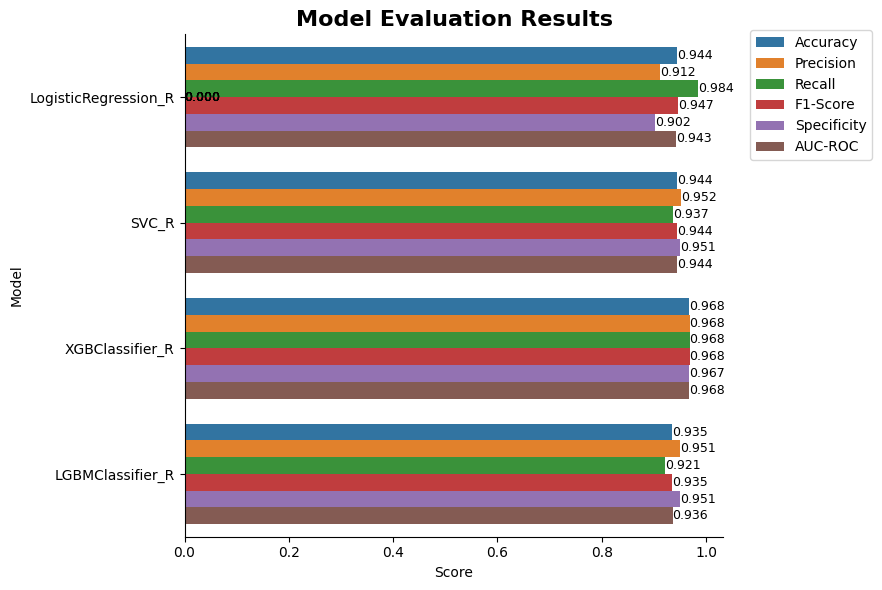

In [70]:
# Prepare data for plotting
plot_df = pd.melt(TESTING_SCORES_R, id_vars=["Model"])
plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)

PLOT = sns.catplot(
    x="Score", 
    y="Model", 
    hue="Metric", 
    data=plot_df, 
    kind="bar", 
    orient="h",
    height=6, 
    aspect=1.5, 
    legend_out=False,
    palette="tab10"  
)

# Access the axes of the plot
ax = PLOT.axes[0, 0]

# Annotate the bars with their corresponding scores
for p in ax.patches:
    ax.annotate(f"{p.get_width():.3f}", 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left", va="center", fontsize=9)

# Set plot title and legend
plt.title("Model Evaluation Results", fontsize=16, fontweight='bold')
plt.legend(loc=(1.05, 0.75))
plt.tight_layout()

# Display the plot
plt.show()


In [71]:
TRAINED_XGB_R = MODEL_CONTAINER_R["XGBClassifier_R"]
TRAINED_LGBM_R = MODEL_CONTAINER_R["LGBMClassifier_R"]
TRAINED_SVM_R = MODEL_CONTAINER_R["SVC_R"]
TRAINED_LOGREG_R = MODEL_CONTAINER_R["LogisticRegression_R"]

In [72]:
MODELS_TESTING_SCORES = pd.concat([TESTING_SCORES, TESTING_SCORES_R], axis=0)
MODELS_TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0    LogisticRegression  0.943548   0.911765  0.984127  0.946565     0.901639   
1                   SVC  0.935484   0.936508  0.936508  0.936508     0.934426   
2         XGBClassifier  0.959677   0.953125  0.968254  0.960630     0.950820   
3        LGBMClassifier  0.927419   0.950000  0.904762  0.926829     0.950820   
4      TabNetClassifier  0.830645   0.920000  0.730159  0.814159     0.934426   
0  LogisticRegression_R  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC_R  0.943548   0.951613  0.936508  0.944000     0.950820   
2       XGBClassifier_R  0.967742   0.968254  0.968254  0.968254     0.967213   
3      LGBMClassifier_R  0.935484   0.950820  0.920635  0.935484     0.950820   

    AUC-ROC  
0  0.942883  
1  0.935467  
2  0.959537  
3  0.927791  
4  0.832292  
0  0.942883  
1  0.943664  
2  0.967734  
3  0.935727

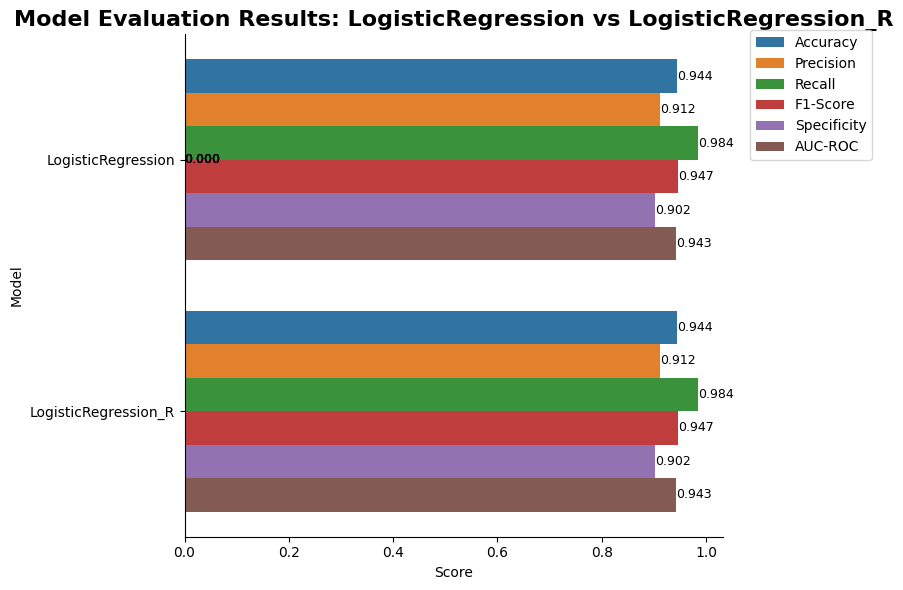

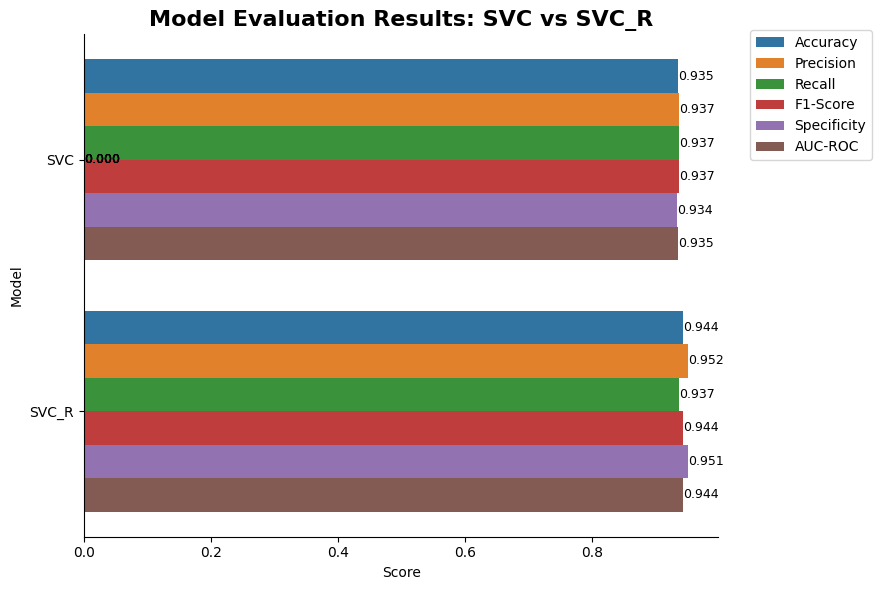

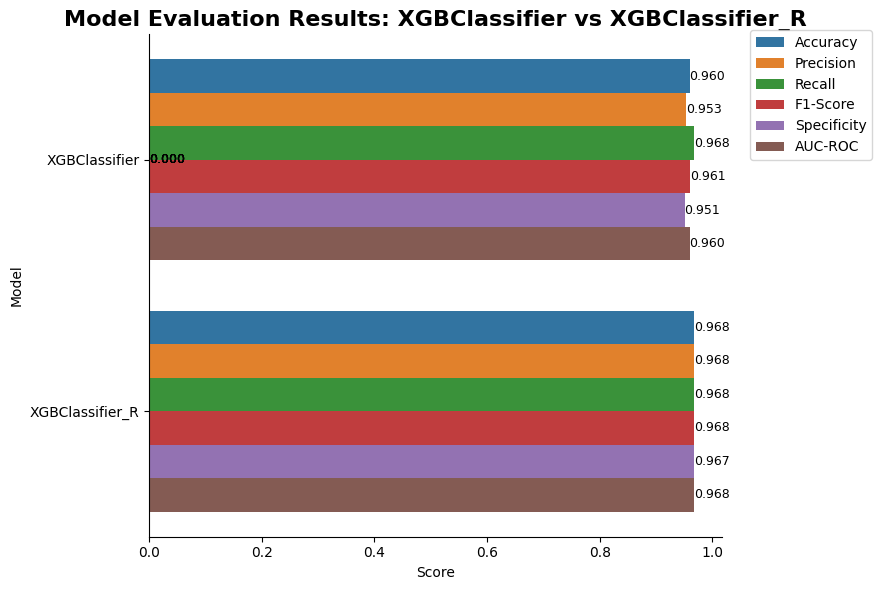

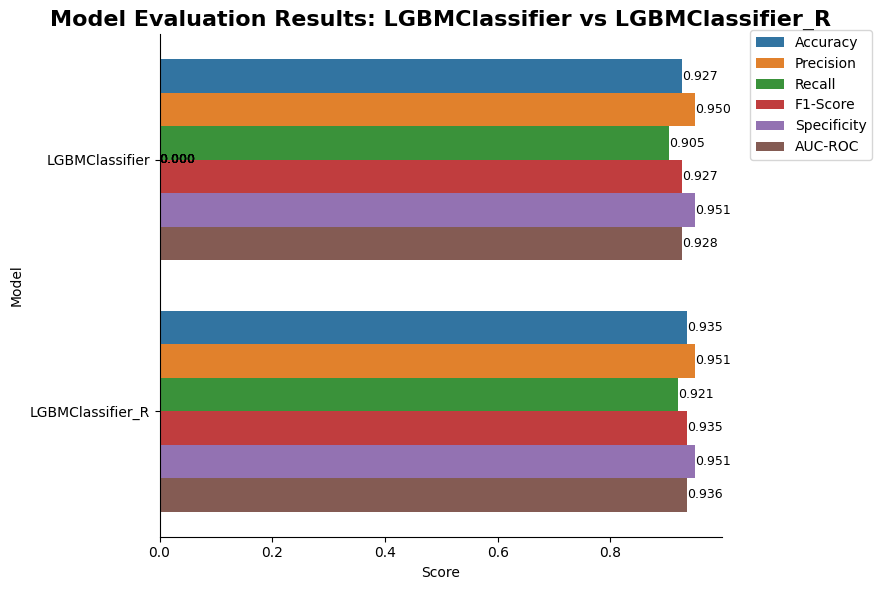

In [73]:
normal_models = TESTING_SCORES['Model'].unique()
reduced_models = TESTING_SCORES_R['Model'].unique()

# Loop through each model and its reduced counterpart
for normal_model, reduced_model in zip(normal_models, reduced_models):
    
    # Filter out the scores for the current model and its reduced counterpart
    normal_model_scores = TESTING_SCORES[TESTING_SCORES['Model'] == normal_model]
    reduced_model_scores = TESTING_SCORES_R[TESTING_SCORES_R['Model'] == reduced_model]
    
    # Combine the scores into one dataframe for plotting
    combined_scores = pd.concat([normal_model_scores, reduced_model_scores])

    # Prepare data for plotting
    plot_df = pd.melt(combined_scores, id_vars=["Model"])
    plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)
    
    PLOT = sns.catplot(
        x="Score", 
        y="Model", 
        hue="Metric", 
        data=plot_df, 
        kind="bar", 
        orient="h",
        height=6, 
        aspect=1.5, 
        legend_out=False,
        palette="tab10"  
    )
    
    # Access the axes of the plot
    ax = PLOT.axes[0, 0]
    
    # Annotate the bars with their corresponding scores
    for p in ax.patches:
        ax.annotate(f"{p.get_width():.3f}", 
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                    ha="left", va="center", fontsize=9)
    
    # Set plot title for each model and its reduced version
    plt.title(f"Model Evaluation Results: {normal_model} vs {reduced_model}", fontsize=16, fontweight='bold')
    
    # Set legend and show the plot
    plt.legend(loc=(1.05, 0.75))
    plt.tight_layout()
    plt.show()


In [74]:
XGB_PREDICTED_PROBA = TRAINED_XGB.predict_proba(X_test)
XGB_R_PREDICTED_PROBA = TRAINED_XGB_R.predict_proba(X_test_xgb)
LOGREG_R_PREDICTED_PROBA = TRAINED_LOGREG_R.predict_proba(X_test_logreg)

LGBM_R_PREDICTED_PROBA = TRAINED_LGBM_R.predict_proba(X_test_lgbm)


In [75]:
weight_xgb = 0.3
weight_xgb_r = 0.3
weight_logreg_r = 0.3
weight_lgbm_r = 0.3

TOP3_WAVERAGE_PREDICTIONS = (weight_xgb_r * XGB_R_PREDICTED_PROBA + weight_xgb * XGB_PREDICTED_PROBA + weight_logreg_r * LOGREG_R_PREDICTED_PROBA) / (weight_xgb_r + weight_xgb + weight_logreg_r)

TOP3_WAVERAGE_PREDICTIONS_R = (weight_xgb_r * XGB_R_PREDICTED_PROBA + weight_lgbm_r * LGBM_R_PREDICTED_PROBA + weight_logreg_r * LOGREG_R_PREDICTED_PROBA) / (weight_xgb_r + weight_lgbm_r + weight_logreg_r)

In [76]:
TOP3_LABELED_PREDICTIONS = np.argmax(TOP3_WAVERAGE_PREDICTIONS, axis=1)

TOP3_LABELED_PREDICTIONS_R = np.argmax(TOP3_WAVERAGE_PREDICTIONS_R, axis=1)

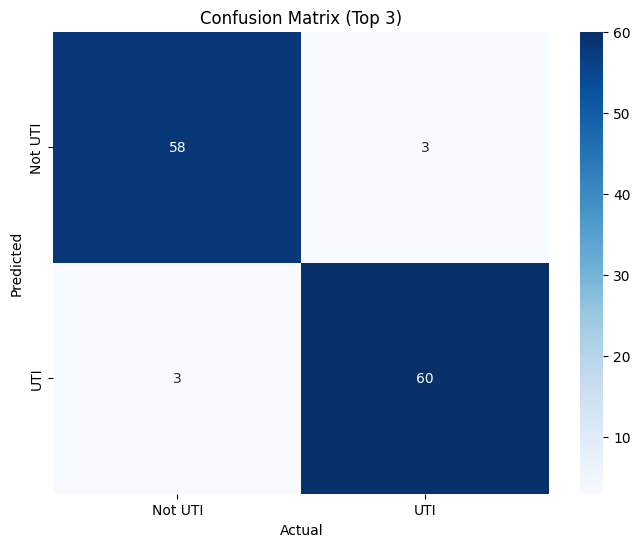

In [77]:
T3_CM = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS)

plt.figure(figsize=(8, 6))
sns.heatmap(T3_CM, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["Not UTI", "UTI"], yticklabels=["Not UTI", "UTI"])
plt.title("Confusion Matrix (Top 3)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

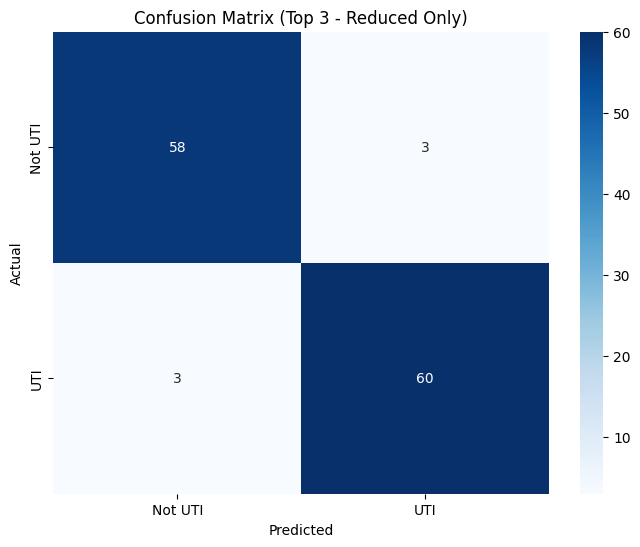

In [78]:
T3_CM_R = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS_R)

plt.figure(figsize=(8, 6))
sns.heatmap(T3_CM_R, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["Not UTI", "UTI"], yticklabels=["Not UTI", "UTI"])
plt.title("Confusion Matrix (Top 3 - Reduced Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [79]:
# Compute evaluation metrics using scikit-learn functions
T3_ACCURACY = accuracy_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_F1 = f1_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_RECALL = recall_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_PRECISION = precision_score(y_test, TOP3_LABELED_PREDICTIONS)

T3R_ACCURACY = accuracy_score(y_test, TOP3_LABELED_PREDICTIONS_R)
T3R_F1 = f1_score(y_test, TOP3_LABELED_PREDICTIONS_R)
T3R_RECALL = recall_score(y_test, TOP3_LABELED_PREDICTIONS_R)
T3R_PRECISION = precision_score(y_test, TOP3_LABELED_PREDICTIONS_R)

# Compute additional metrics (confusion matrix, specificity, ROC AUC)
T3_TN, T3_FP, _, _ = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS).ravel()
T3_SPECIFICITY = T3_TN / (T3_TN + T3_FP)
T3_ROC_AUC = roc_auc_score(y_test, TOP3_LABELED_PREDICTIONS)

T3R_TN, T3R_FP, _, _ = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS_R).ravel()
T3R_SPECIFICITY = T3R_TN / (T3R_TN + T3R_FP)
T3R_ROC_AUC = roc_auc_score(y_test, TOP3_LABELED_PREDICTIONS_R)

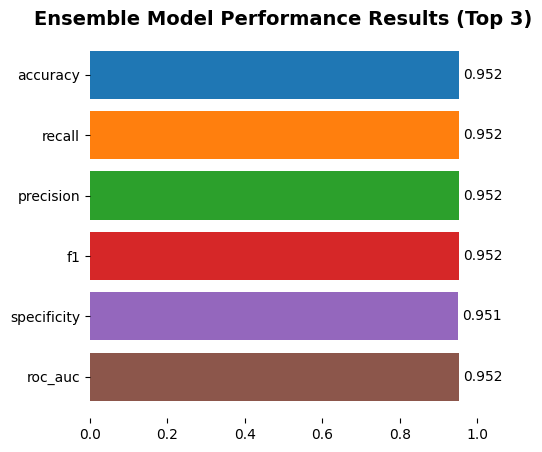

In [80]:
# Create a horizontal bar plot with specified figure size
fig, axs = plt.subplots(figsize=(5, 5))

bar_graph = axs.barh(
    ["accuracy", "recall", "precision", "f1", "specificity", "roc_auc"],
    [T3_ACCURACY, T3_RECALL, T3_PRECISION, T3_F1, T3_SPECIFICITY, T3_ROC_AUC],
    color=sns.color_palette("tab10")  
)


# Add labels to the bars with the corresponding values
axs.bar_label(bar_graph, labels=[f"{x:.3f}" for x in bar_graph.datavalues], padding=3)

# Remove spines for aesthetics
for spine in ["top", "bottom", "left", "right"]:
    axs.spines[spine].set_visible(False)

# Invert y-axis for better visualization
axs.invert_yaxis()

# Set plot title and display the plot
plt.title("Ensemble Model Performance Results (Top 3)", fontsize=14, fontweight='bold')
plt.show()


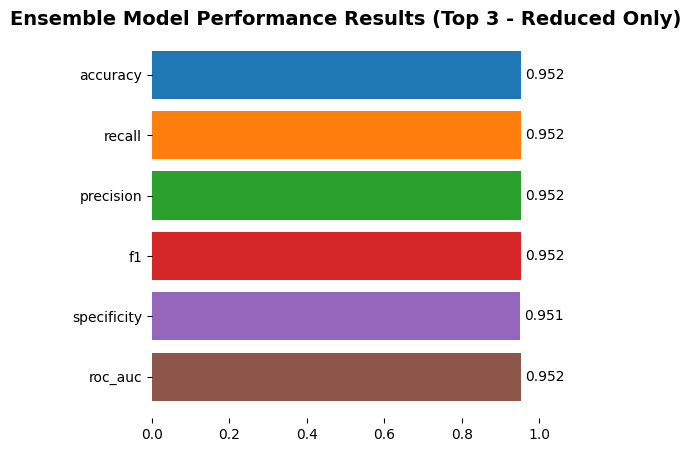

In [81]:
# Create a horizontal bar plot with specified figure size
fig, axs = plt.subplots(figsize=(5, 5))

bar_graph = axs.barh(
    ["accuracy", "recall", "precision", "f1", "specificity", "roc_auc"],
    [T3R_ACCURACY, T3R_RECALL, T3R_PRECISION, T3R_F1, T3R_SPECIFICITY, T3R_ROC_AUC],
    color=sns.color_palette("tab10")  
)


# Add labels to the bars with the corresponding values
axs.bar_label(bar_graph, labels=[f"{x:.3f}" for x in bar_graph.datavalues], padding=3)

# Remove spines for aesthetics
for spine in ["top", "bottom", "left", "right"]:
    axs.spines[spine].set_visible(False)

# Invert y-axis for better visualization
axs.invert_yaxis()

# Set plot title and display the plot
plt.title("Ensemble Model Performance Results (Top 3 - Reduced Only)", fontsize=14, fontweight='bold')
plt.show()


In [82]:
# Save each model
import joblib
joblib.dump(TRAINED_XGB, "trained_xgb_model.pkl")
joblib.dump(TRAINED_LOGREG, "trained_logreg_model.pkl")
joblib.dump(TRAINED_SVM, "trained_svm_model.pkl")
joblib.dump(TRAINED_XGB_R, "trained_xgb_r_model.pkl")
joblib.dump(TRAINED_LOGREG_R, "trained_logreg_r_model.pkl")
joblib.dump(TRAINED_LGBM_R, "trained_lgbm_r_model.pkl")


['trained_lgbm_r_model.pkl']

In [83]:
ensemble_weights = {'weight_xgb': 0.33, 'weight_xgb_r': 0.33, 'weight_logreg_r': 0.33, 'weight_lgbm_r': 0.33}
joblib.dump(ensemble_weights, "ensemble_weights.pkl")

['ensemble_weights.pkl']

In [84]:

data = {
    'Model': ['LogisticRegression', 'SVC', 'XGBClassifier', 'LGBMClassifier', 'TabNetClassifier'],
    'Accuracy': [0.943548, 0.935484, 0.959677, 0.927419, 0.862903],
    'Precision': [0.911765, 0.936508, 0.953125, 0.950000, 0.925926],
    'Recall': [0.984127, 0.936508, 0.968254, 0.904762, 0.793651],
    'Specificity': [0.901639, 0.934426, 0.950820, 0.950820, 0.934426],
    'AUC-ROC': [0.942883, 0.935467, 0.959537, 0.927791, 0.864039],

}


df = pd.DataFrame(data)

Z = 1.96

def compute_ci(row, metric):
    p = row[metric]  
    n = 123 
    se = np.sqrt((p * (1 - p)) / n)  
    lower = max(0, p - Z * se)  
    upper = min(1, p + Z * se)  
    return pd.Series([lower, upper])

# Compute confidence intervals for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'AUC-ROC']
for metric in metrics:
    df[[f'{metric}_Lower', f'{metric}_Upper']] = df.apply(compute_ci, metric=metric, axis=1)

# Display the updated DataFrame
df


Model  Accuracy  Precision    Recall  Specificity   AUC-ROC  \
0  LogisticRegression  0.943548   0.911765  0.984127     0.901639  0.942883   
1                 SVC  0.935484   0.936508  0.936508     0.934426  0.935467   
2       XGBClassifier  0.959677   0.953125  0.968254     0.950820  0.959537   
3      LGBMClassifier  0.927419   0.950000  0.904762     0.950820  0.927791   
4    TabNetClassifier  0.862903   0.925926  0.793651     0.934426  0.864039   

   Accuracy_Lower  Accuracy_Upper  Precision_Lower  Precision_Upper  \
0        0.902761        0.984335         0.861639         0.961891   
1        0.892067        0.978901         0.893414         0.979602   
2        0.924912        0.994442         0.915770         0.990480   
3        0.881568        0.973270         0.911483         0.988517   
4        0.802118        0.923688         0.879643         0.972209   

   Recall_Lower  Recall_Upper  Specificity_Lower  Specificity_Upper  \
0      0.962039      1.000000           0.849009           0.954269   
1      0.893414      0.979602           0.890680           0.978172   
2      0.937270      0.999238           0.912604           0.989036   
3      0.852885      0.956639           0.912604           0.989036   
4      0.722132      0.865170           0.890680           0.978172   

   AUC-ROC_Lower  AUC-ROC_Upper  
0       0.901871       0.983895  
1       0.892045       0.978889  
2       0.924714       0.994360  
3       0.882048       0.973534  
4       0.803466       0.924612

In [85]:
import numpy as np
import pandas as pd

# Updated DataFrame
data = {
    'Model': ['LogisticRegression_R', 'SVC_R', 'XGBClassifier_R', 'LGBMClassifier_R'],
    'Accuracy': [0.951613, 0.927419, 0.967742, 0.935484],
    'Precision': [0.925373, 0.935484, 0.968254, 0.950820],
    'Recall': [0.984127, 0.920635, 0.968254, 0.920635],
    'Specificity': [0.918033, 0.934426, 0.967213, 0.950820],
    'AUC-ROC': [0.951080, 0.927531, 0.967734, 0.935727],
}

df = pd.DataFrame(data)

# Z-score for 95% confidence level
Z = 1.96

# Function to compute confidence intervals
def compute_ci(row, metric):
    p = row[metric]  # Proportion (e.g., accuracy, precision, etc.)
    n = 123  # Replace with the actual size of your test set
    se = np.sqrt((p * (1 - p)) / n)  # Standard error
    lower = max(0, p - Z * se)  # Clip to 0
    upper = min(1, p + Z * se)  # Clip to 1
    return pd.Series([lower, upper])

# Compute confidence intervals for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'AUC-ROC']
for metric in metrics:
    df[[f'{metric}_Lower', f'{metric}_Upper']] = df.apply(compute_ci, metric=metric, axis=1)

# Display the updated DataFrame
df


Model  Accuracy  Precision    Recall  Specificity   AUC-ROC  \
0  LogisticRegression_R  0.951613   0.925373  0.984127     0.918033  0.951080   
1                 SVC_R  0.927419   0.935484  0.920635     0.934426  0.927531   
2       XGBClassifier_R  0.967742   0.968254  0.968254     0.967213  0.967734   
3      LGBMClassifier_R  0.935484   0.950820  0.920635     0.950820  0.935727   

   Accuracy_Lower  Accuracy_Upper  Precision_Lower  Precision_Upper  \
0        0.913690        0.989536         0.878931         0.971815   
1        0.881568        0.973270         0.892067         0.978901   
2        0.936517        0.998967         0.937270         0.999238   
3        0.892067        0.978901         0.912604         0.989036   

   Recall_Lower  Recall_Upper  Specificity_Lower  Specificity_Upper  \
0      0.962039      1.000000           0.869554           0.966512   
1      0.872864      0.968406           0.890680           0.978172   
2      0.937270      0.999238           0.935742           0.998684   
3      0.872864      0.968406           0.912604           0.989036   

   AUC-ROC_Lower  AUC-ROC_Upper  
0       0.912960       0.989200  
1       0.881712       0.973350  
2       0.936505       0.998963  
3       0.892387       0.979067

In [86]:
import numpy as np
import pandas as pd

# Updated DataFrame
data = {
    'Model': ['Ensemble_Overall', 'Ensemble_Reduced'],
    'Accuracy': [0.952, 0.944],
    'Precision': [0.952, 0.937],
    'Recall': [0.952, 0.952],
    'Specificity': [0.951, 0.951],
    'AUC-ROC': [0.952, 0.944],
}

df = pd.DataFrame(data)

# Z-score for 95% confidence level
Z = 1.96

# Function to compute confidence intervals
def compute_ci(row, metric):
    p = row[metric]  # Proportion (e.g., accuracy, precision, etc.)
    n = 123  # Replace with the actual size of your test set
    se = np.sqrt((p * (1 - p)) / n)  # Standard error
    lower = max(0, p - Z * se)  # Clip to 0
    upper = min(1, p + Z * se)  # Clip to 1
    return pd.Series([lower, upper])

# Compute confidence intervals for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'AUC-ROC']
for metric in metrics:
    df[[f'{metric}_Lower', f'{metric}_Upper']] = df.apply(compute_ci, metric=metric, axis=1)

# Display the updated DataFrame
df


Model  Accuracy  Precision  Recall  Specificity  AUC-ROC  \
0  Ensemble_Overall     0.952      0.952   0.952        0.951    0.952   
1  Ensemble_Reduced     0.944      0.937   0.952        0.951    0.944   

   Accuracy_Lower  Accuracy_Upper  Precision_Lower  Precision_Upper  \
0        0.914222        0.989778         0.914222         0.989778   
1        0.903367        0.984633         0.894062         0.979938   

   Recall_Lower  Recall_Upper  Specificity_Lower  Specificity_Upper  \
0      0.914222      0.989778            0.91285            0.98915   
1      0.914222      0.989778            0.91285            0.98915   

   AUC-ROC_Lower  AUC-ROC_Upper  
0       0.914222       0.989778  
1       0.903367       0.984633

In [87]:
# complete_cols = X.columns

In [88]:
# data_agdeppa = pd.read_csv('agdeppa_encoded_dataset.csv')
# data_agdeppa

In [89]:
# missing_columns = list(set(complete_cols) - set(data_agdeppa))
# print(f"Missing Columns: {missing_columns}")

In [90]:

# # Find missing columns
# missing_columns = list(set(complete_cols) - set(data_agdeppa.columns))

# # Print the missing columns
# print(f"Missing Columns: {missing_columns}")

In [91]:
# if "DIAGNOSIS" not in complete_cols:
#     complete_cols = list(complete_cols)  # Convert Index to a list
#     complete_cols.append("DIAGNOSIS")  # Append DIAGNOSIS
#     complete_cols = pd.Index(complete_cols)  # Convert back to Index

# # Ensure all columns in complete_cols exist in data_agdeppa
# reordered_cols = [col for col in complete_cols if col in data_agdeppa.columns]

# # Reorder columns safely without removing DIAGNOSIS
# data_agdeppa = data_agdeppa[reordered_cols]

In [92]:
# # Convert complete_cols to a list if necessary
# complete_cols = list(complete_cols) if isinstance(complete_cols, pd.Index) else complete_cols

# # Identify missing columns
# missing_cols = [col for col in complete_cols if col not in data_agdeppa.columns]

# # Add missing columns with a default value of 0
# for col in missing_cols:
#     data_agdeppa[col] = -1

# # Reorder columns to match complete_cols
# data_agdeppa = data_agdeppa[complete_cols]

In [93]:
# data_agdeppa

In [94]:
# data_agdeppa.to_csv("agdeppa_encoded_dataset_filled.csv")